In [771]:
'''
from google.colab import drive

drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\n\ndrive.mount('/content/drive')\n"

In [772]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import statsmodels.api as sm


#%cd "/content/drive/MyDrive/Inteligencia Artificial"
data = pd.read_csv("dataus2024.csv")
data.shape

(557181, 24)

In [773]:
firms = pd.read_csv('firmsus2024.csv')
firms.shape

(5689, 7)

In [774]:
print(type(data.head()))

<class 'pandas.core.frame.DataFrame'>


In [775]:
# Concat de data con firms para jalar columnas de industria, nombre empresa en data
firms1 = firms[["empresa", "Nombre", "status", "naics1"]]
firms1.columns = ["firm", "Empresa", "status", "industria"]

data = pd.merge(data, firms1, on="firm", how="left")
data.head()

firm       q  fiscalmonth     revenue       cogs       sgae  otherincome  \
0    A  2000q1          NaN         NaN        NaN        NaN          NaN   
1    A  2000q2          6.0   4731000.0  2421000.0  1925000.0      73000.0   
2    A  2000q3          9.0   7401000.0  3790000.0  3016000.0     101000.0   
3    A  2000q4         12.0  10773000.0  5522000.0  4198000.0     111000.0   
4    A  2001q1          3.0   2841000.0  1449000.0  1113000.0      19000.0   

   extraordinaryitems  finexp  incometax  ...  originalprice  \
0                 NaN     NaN        NaN  ...       104.0000   
1                 0.0     0.0   161000.0  ...        73.7500   
2                 0.0     0.0   244000.0  ...        48.9375   
3                 0.0     0.0   407000.0  ...        54.7500   
4            -25000.0     0.0   119000.0  ...        30.7300   

   sharesoutstanding  year  fixedassets   yearf  cto  fiscalq  \
0         452000.000  2000          NaN     NaN    1      NaN   
1         452271.967  2000    1453000.0  2000.0    2      2.0   
2         453014.579  2000    1581000.0  2000.0    3      3.0   
3         456366.381  2000    1741000.0  2000.0    4      4.0   
4         456769.737  2001    1821000.0  2001.0    1      1.0   

                     Empresa  status                  industria  
0  Agilent Technologies, Inc  activo  Industrias manufactureras  
1  Agilent Technologies, Inc  activo  Industrias manufactureras  
2  Agilent Technologies, Inc  activo  Industrias manufactureras  
3  Agilent Technologies, Inc  activo  Industrias manufactureras  
4  Agilent Technologies, Inc  activo  Industrias manufactureras  

[5 rows x 27 columns]

Calculo la variable columna de NetIncome y otras asociadas:

**Utilidad bruta = Gross Profit =** $Revenue - COGS$

**COGS = Cost of Good Sold; son los gastos VARIABLES; cambian con las ventas**

**Utilidad operativa antes de impuesto = Earnings before Onterests and Taxes**

**EBIT (Utilidad Operativa Antes de Impuestos) =** $Gross profit - SGAE$

*SGAE = Safe and General Administrative Expenses

**Net Income =** $EBIT - FINEXP - INCOMETAX + OTHERINCOME + EXTRAORDINARYITEMS$

*FINEXP = Pago de Intereses de Préstamos

*INCOMETAX = Pago de Impuesto Sobre la Renta

*OTHERINCOME = Otras ventas que no sean del core del negocio

*EXTRAORDINARYITEMS = Ventas extraordinarias

*ETB = Utilidad antes de impuesto

*NETINCOME = Utilidad neta, es decir, todas las ganancias menos los gastos


*NOPAT = 

In [776]:
data["GROSSPROFIT"] = data["revenue"] - data["cogs"]
data["EBIT"] = data["GROSSPROFIT"] - data["sgae"]
data["NETINCOME"] = data["EBIT"] - data["finexp"] - data["incometax"] + data["otherincome"] + data["extraordinaryitems"]
data["EBT"] = data['EBIT'] - data["finexp"] + data["otherincome"] + data["extraordinaryitems"]
data['Effective_Tax_Rate'] = data['incometax'] / data['EBT']
data['NOPAT'] = data['EBIT'] * (1 - data['Effective_Tax_Rate'])
data['NOPAT'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_7892\2485459827.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['NOPAT'].replace([np.inf, -np.inf], np.nan, inplace=True)


Cálculo de Valor de Mercado y Valor en Libros

Valor de Mercado = MARKET VALUE = $originalprice * sharesoutstanding$
originalprice = precio original de la acción
sharepitstanding = Número de acciones disponibles


Valor en Libros = BOOKVALUE = $totalassets - totalliabilities$

totalassets = total de activos (recursos)

totalliabilities = total de pasivos

In [777]:
data['BOOKVALUE'] = data['totalassets'] - data['totalliabilities']
data['MARKETVALUE'] = data['originalprice'] * data['sharesoutstanding']
data['BOOKMARKET'] = data['BOOKVALUE'] / data['MARKETVALUE']

El BOOK-TO-MARKET es una variable de "Control" que vamos a incluir en el modelo de regresión.

En estadística se le llama variable de control a aquellas variables independientes (explicativas) que en la disciplina de estudio se ha encontrado que tiene mucha correlación con la variable dependiente.

Generamos la $variable / ratio$ de earning per share, que será otra variable de control

**¿Qué es earning per share deflated by price?**

**¿Qué es Earnings?**

Earning se puede medir con alguna variable de utilidad.
Ejemplo:
- NETINCOME
- EBIT (Utilidad Operativa)

**EARNING PER SHARE = EPS =** $EARNINGS / shareoutstanding$

**EARNING PER SHARE DEFLATED BY PRICE = EPSP =** $EPS / originalprice$

In [778]:
data['EPS'] = data['NETINCOME'] / data['sharesoutstanding']
data['EPSP'] = data['EPS'] / data['originalprice']

Ahora calculamos los retornos de acción para todas las empresas (trimestrales y anuales)

**Retorno trimestral = QR =** adjprice / adjprice{t-1} -1

**Retorno anual = YR =** adjprice / adjprice{t-4} - 1

Retornos Continuos Compuestos:

ret trimestral = qr = log(adjprice) - log(adjprice{t-1}) = log(adjprice / adjprice{t-1})

ret anual = yr = log(adjprice) - log(adjprice{t-4})


Genero un úndice en el dataset por firm-quarter:

In [779]:
data['qdate'] = pd.PeriodIndex(data.q, freq = 'Q')
data.set_index(['firm', 'qdate'], inplace = True)
data.head()
data.index

MultiIndex([(     'A', '2000Q1'),
            (     'A', '2000Q2'),
            (     'A', '2000Q3'),
            (     'A', '2000Q4'),
            (     'A', '2001Q1'),
            (     'A', '2001Q2'),
            (     'A', '2001Q3'),
            (     'A', '2001Q4'),
            (     'A', '2002Q1'),
            (     'A', '2002Q2'),
            ...
            ('ZY_old', '2022Q1'),
            ('ZY_old', '2022Q2'),
            ('ZY_old', '2022Q3'),
            ('ZY_old', '2022Q4'),
            ('ZY_old', '2023Q1'),
            ('ZY_old', '2023Q2'),
            ('ZY_old', '2023Q3'),
            ('ZY_old', '2023Q4'),
            ('ZY_old', '2024Q1'),
            ('ZY_old', '2024Q2')],
           names=['firm', 'qdate'], length=557181)

Calcular los CC Returns para cada trimestre y anual de cada firma.

In [780]:
# Quarter returns
data['return_q'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(1))
# Yearly returns
data['return_y'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(4))
print(data.head())

                  q  fiscalmonth     revenue       cogs       sgae  \
firm qdate                                                           
A    2000Q1  2000q1          NaN         NaN        NaN        NaN   
     2000Q2  2000q2          6.0   4731000.0  2421000.0  1925000.0   
     2000Q3  2000q3          9.0   7401000.0  3790000.0  3016000.0   
     2000Q4  2000q4         12.0  10773000.0  5522000.0  4198000.0   
     2001Q1  2001q1          3.0   2841000.0  1449000.0  1113000.0   

             otherincome  extraordinaryitems  finexp  incometax  totalassets  \
firm qdate                                                                     
A    2000Q1          NaN                 NaN     NaN        NaN          NaN   
     2000Q2      73000.0                 0.0     0.0   161000.0    7321000.0   
     2000Q3     101000.0                 0.0     0.0   244000.0    7827000.0   
     2000Q4     111000.0                 0.0     0.0   407000.0    8425000.0   
     2001Q1      19000.0     

Calcule los rendimientos CC returns futuros (un cuarto por delante)

In [781]:
data['return_q_future'] = data.groupby(['firm'])['return_q'].shift(-1)
#data['return_q_future'] = data.groupby(['firm'])['return_q'].shift(-4)

#data['return_y_future'] = data.groupby(['firm'])['return_y'].shift(-1)
data['return_y_future'] = data.groupby(['firm'])['return_y'].shift(-4)

print(data.head())

                  q  fiscalmonth     revenue       cogs       sgae  \
firm qdate                                                           
A    2000Q1  2000q1          NaN         NaN        NaN        NaN   
     2000Q2  2000q2          6.0   4731000.0  2421000.0  1925000.0   
     2000Q3  2000q3          9.0   7401000.0  3790000.0  3016000.0   
     2000Q4  2000q4         12.0  10773000.0  5522000.0  4198000.0   
     2001Q1  2001q1          3.0   2841000.0  1449000.0  1113000.0   

             otherincome  extraordinaryitems  finexp  incometax  totalassets  \
firm qdate                                                                     
A    2000Q1          NaN                 NaN     NaN        NaN          NaN   
     2000Q2      73000.0                 0.0     0.0   161000.0    7321000.0   
     2000Q3     101000.0                 0.0     0.0   244000.0    7827000.0   
     2000Q4     111000.0                 0.0     0.0   407000.0    8425000.0   
     2001Q1      19000.0     

Calcular al menos 4 financial ratios para cada variable independiente que será usada para predecir el futuro stock return

**ROE (Return On Equity):** Ganancias netas / Inversión de capital de accionistas.

Mide rentabilidad y ediciencia de la empresa al momento de generar rendimientos para la inversión de capital de accionistas (eficacia del dinero de los accionistas una empresa para generar ganancias). Mayor ROE = Uso eficiente del capital. Lo escogí debido a que es un indicador directo de la rentabilidad del capital, ya que una empresa con un ROE alto es atractivo a los inversores porque les da a entender que pueden generar beneficios sólidos con sus inversiones.

In [782]:
# Return on Equity (ROE)
data['ROE'] = data['NETINCOME'] / data['BOOKVALUE']
data['ROE'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_7892\702537394.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ROE'].replace([np.inf, -np.inf], np.nan, inplace=True)


**NPM (Net Profit Margin):** Ganancias netas / Ingresos

Mide el porcentaje de ganancias que produce una compañia en comparación con sus ingresos. Tiene un enfoque en la rentabilidad de la empresa. Escogí este ratio debido a que un NPM alto quiere decir que la empresa tiene un buen control de costos y que sus operaciones son eficientes, por lo que puede ser clave para predecir el retorno futuro de las inversiones.

In [783]:
# Net Profit Margin
data['NPM'] = data['NETINCOME'] / data['revenue']
data['NPM'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_7892\3479908675.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['NPM'].replace([np.inf, -np.inf], np.nan, inplace=True)


**ROIC (Return on Invested Capital):** Utilidad operativa neta después de impuestos / Capital invertido

Mide la eficiencia con la que una empresa usa su capital para generar utilidad. Un ROIC alto indica que la empresa está obteniendo un alto rendimiento por cada unidad unidad de capital invertido. Escogí este ratio porque es un indicador de la efectividad con la que una empresa usa su capital total para generar valor. ROIC alto es que una empresa usa su capital de manera eficiente, por lo que puede ser clave para predecir retornos futuros.

In [784]:
# Return on Invested Capital (ROIC)
data['ROIC'] = data['NOPAT'] / data['totalassets']
data['ROIC'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_7892\4238890335.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ROIC'].replace([np.inf, -np.inf], np.nan, inplace=True)


**OPM (Operating Profit Margin):** EBIT / Revenue

Mide el porcentaje de los ingresos que se convierte en utilidades operativas (excluyendo intereses, impuestos, etc). A mayor margen operativo, una empresa es más eficiente de convertir ventas en utilidades (gran capacidad de generar ganancias con las operaciones básicas). Escogí este ratio porque refleja la eficiencia operativa de una empresa, muestra cuánto d elos ingresos se convierten en beneficios operativos. Un OPM alto quiere decir que la empresa tiene control sobre sus costos operativos, lo cual puede ser un factor importante para generar retornos.

In [785]:
# Operating Profit Margin
data['OPM'] = data['EBIT'] / data['revenue']
data['OPM'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_7892\1534909035.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['OPM'].replace([np.inf, -np.inf], np.nan, inplace=True)


**Debt to Equity (DEBTTOEQUITY):** Total Liabilities / Book Value (Equity)

Mide el nivel de endeudamiento financiero de una empresa comparando sus deudas (pasivos totales) con el valor contable de sus activos (patrimonio). Un ratio más alto indica que la empresa está más endeudada en relación con su patrimonio, lo que significa que está financiando sus operaciones principalmente con deuda en lugar de capital propio. Escogí este ratio porque refleja el riesgo financiero de una empresa; una empresa con un alto ratio Debt to Equity puede estar más expuesta a problemas de liquidez y riesgos de insolvencia en tiempos de dificultades económicas, pero también puede beneficiarse de la deuda al generar retornos adicionales a través de inversiones financiadas por esta.

In [786]:
# Debt to Equity
data['DEBTTOEQUITY'] = data['totalliabilities'] / data['BOOKVALUE']
data['DEBTTOEQUITY'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_7892\1656593005.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['DEBTTOEQUITY'].replace([np.inf, -np.inf], np.nan, inplace=True)


**Current Ratio (CURRENTRATIO):**  Current Assets / Current Liabilities

Mide la capacidad de una empresa para pagar sus deudas a corto plazo con sus activos corrientes. Un ratio más alto indica que la empresa tiene suficientes activos líquidos para cubrir sus pasivos inmediatos, lo que sugiere una buena salud financiera en términos de liquidez. Escogí este ratio porque refleja la capacidad de la empresa para manejar sus obligaciones a corto plazo sin necesidad de recurrir a financiación adicional o vender activos importantes. Un Current Ratio bajo podría indicar problemas de liquidez, mientras que un ratio muy alto podría significar que la empresa no está utilizando sus activos de manera eficiente para generar crecimiento o retorno.

In [787]:
# Current Ratio
data['CURRENTRATIO'] = data['currentassets'] / data['currentliabilities']
data['CURRENTRATIO'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_7892\753272855.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CURRENTRATIO'].replace([np.inf, -np.inf], np.nan, inplace=True)


### 1.2 Composición firme del mercado financiero estadounidense

1. Empresas activas por industria hay en la muestra

In [788]:
active_firms = data[data['status'] == 'activo'].groupby('industria')['Empresa'].nunique()
print(active_firms)

industria
-                                                                                                   2
Agricultura, ganadería, aprovechamiento forestal, pesca y caza                                     17
Comercio al por mayor                                                                              74
Comercio al por menor                                                                             141
Construcción                                                                                       47
Empresas de electricidad, gas y agua                                                               78
Industrias manufactureras                                                                        1499
Información en medios masivos                                                                     243
Minería, explotación de canteras y extracción de petróleo y gas                                   109
Otros servicios excepto actividades gubernamentales                     

In [789]:
total_active_firms = active_firms.sum()
print('Total de empresas activas en todas las industrias:', total_active_firms)

Total de empresas activas en todas las industrias: 3444


2. Tabla de estadísticas sobre el book value y el market value por industria.

In [790]:
# Calcular las estadísticas para 'BOOKVALUE' y 'MARKETVALUE' por industria
bookvalue_stats = data.groupby('industria')['BOOKVALUE'].describe()
marketvalue_stats = data.groupby('industria')['MARKETVALUE'].describe()

# Convertir el resultado de describe a un dataframe. Asignar títulos a las columnas
bookvalue_df = bookvalue_stats.apply(pd.Series).rename(columns=lambda x: f'BOOKVALUE: {x}')
marketvalue_df = marketvalue_stats.apply(pd.Series).rename(columns=lambda x: f'MARKETVALUE: {x}')

# Concatenar los dos df de manera horizontal
statistics = pd.concat([bookvalue_df, marketvalue_df], axis=1)

# Poner a "industria" como columna, no como índice
statistics.reset_index(inplace=True)

print(statistics)


                                            industria  BOOKVALUE: count  \
0                                                   -              31.0   
1   Agricultura, ganadería, aprovechamiento forest...            1019.0   
2                               Comercio al por mayor            6001.0   
3                               Comercio al por menor           12851.0   
4                                        Construcción            3431.0   
5                                        Corporativos              67.0   
6                Empresas de electricidad, gas y agua            8100.0   
7                           Industrias manufactureras           98278.0   
8                       Información en medios masivos           18365.0   
9   Minería, explotación de canteras y extracción ...           10794.0   
10  Otros servicios excepto actividades gubernamen...            1061.0   
11  Servicios de alojamiento temporal y de prepara...            4673.0   
12  Servicios de apoyo a 

**¿Qué se puede decir sobre el tamaño típico de una empresa en términos de valor de mercado y valor contable?**

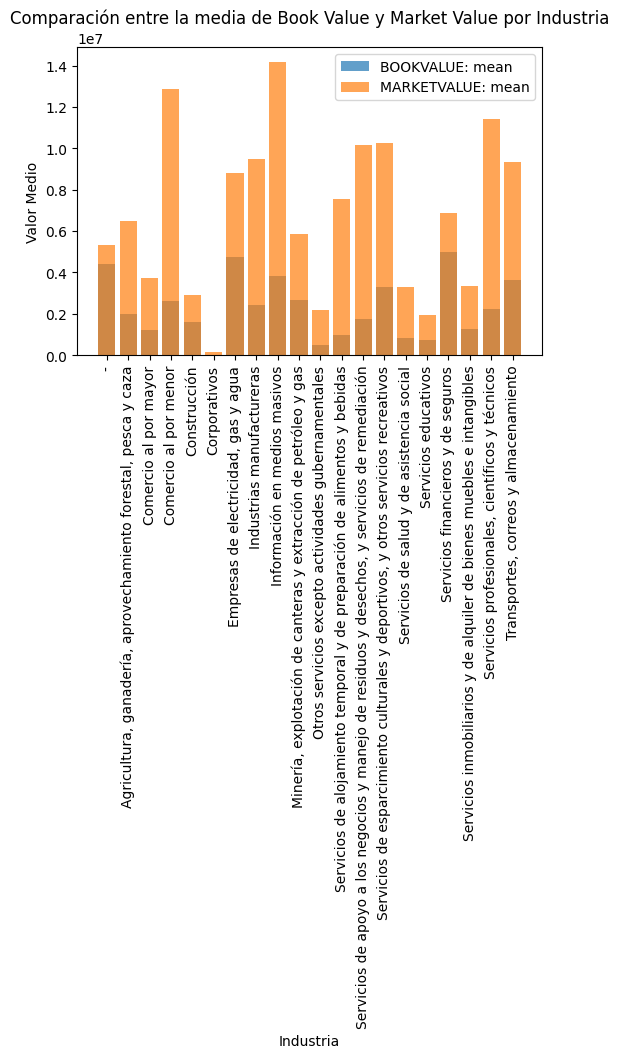

In [791]:
# Calcular la media de BOOKVALUE y MARKETVALUE por industria
bookvalue_mean = data.groupby('industria')['BOOKVALUE'].mean().reset_index()
marketvalue_mean = data.groupby('industria')['MARKETVALUE'].mean().reset_index()
bookvalue_mean = bookvalue_mean.rename(columns={'BOOKVALUE': 'BOOKVALUE_mean'})
marketvalue_mean = marketvalue_mean.rename(columns={'MARKETVALUE': 'MARKETVALUE_mean'})

# Unir ambas medias en un df para graficar
statistics = pd.merge(bookvalue_mean, marketvalue_mean, on='industria')

# Crear la gráfica comparativa
plt.figure(figsize=(6, 4))
plt.bar(statistics['industria'], statistics['BOOKVALUE_mean'], label='BOOKVALUE: mean', alpha=0.7)
plt.bar(statistics['industria'], statistics['MARKETVALUE_mean'], label='MARKETVALUE: mean', alpha=0.7)
plt.xlabel('Industria')
plt.ylabel('Valor Medio')
plt.title('Comparación entre la media de Book Value y Market Value por Industria')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

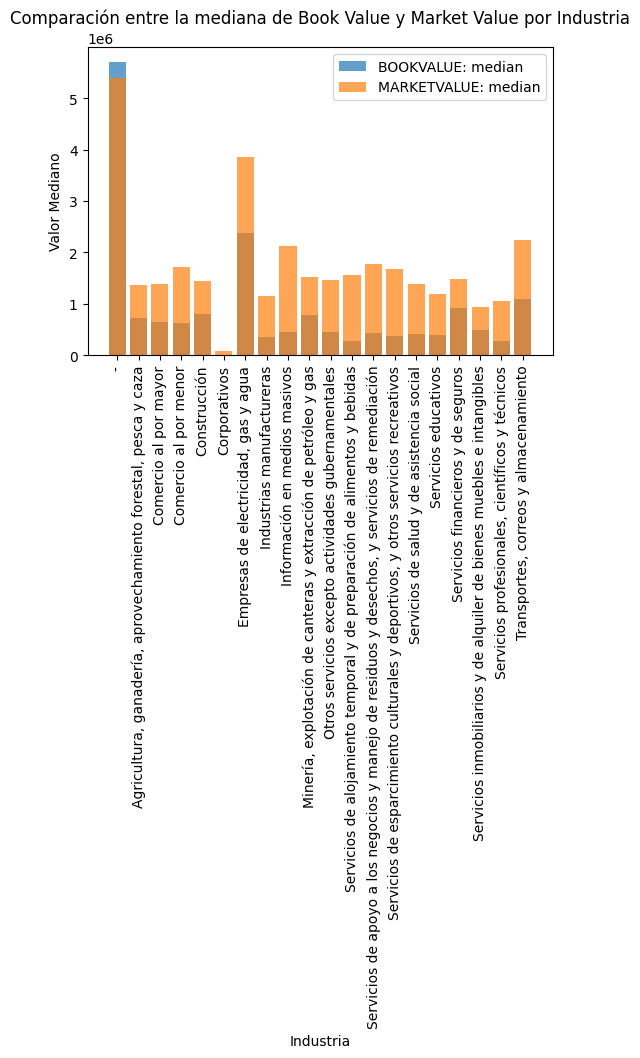

In [792]:
# Calcular la mediana de BOOKVALUE y MARKETVALUE por industria
bookvalue_median = data.groupby('industria')['BOOKVALUE'].median().reset_index()
marketvalue_median = data.groupby('industria')['MARKETVALUE'].median().reset_index()

# Renombrar las columnas para diferenciarlas
bookvalue_median = bookvalue_median.rename(columns={'BOOKVALUE': 'BOOKVALUE_median'})
marketvalue_median = marketvalue_median.rename(columns={'MARKETVALUE': 'MARKETVALUE_median'})

# Unir ambas medianas en un df para graficar
stats_mediana = pd.merge(bookvalue_median, marketvalue_median, on='industria')

# Crear la gráfica comparativa
plt.figure(figsize=(6, 4))
plt.bar(stats_mediana['industria'], stats_mediana['BOOKVALUE_median'], label='BOOKVALUE: median', alpha=0.7)
plt.bar(stats_mediana['industria'], stats_mediana['MARKETVALUE_median'], label='MARKETVALUE: median', alpha=0.7)
plt.xlabel('Industria')
plt.ylabel('Valor Mediano')
plt.title('Comparación entre la mediana de Book Value y Market Value por Industria')
plt.xticks(rotation=90)
plt.legend()
plt.show()


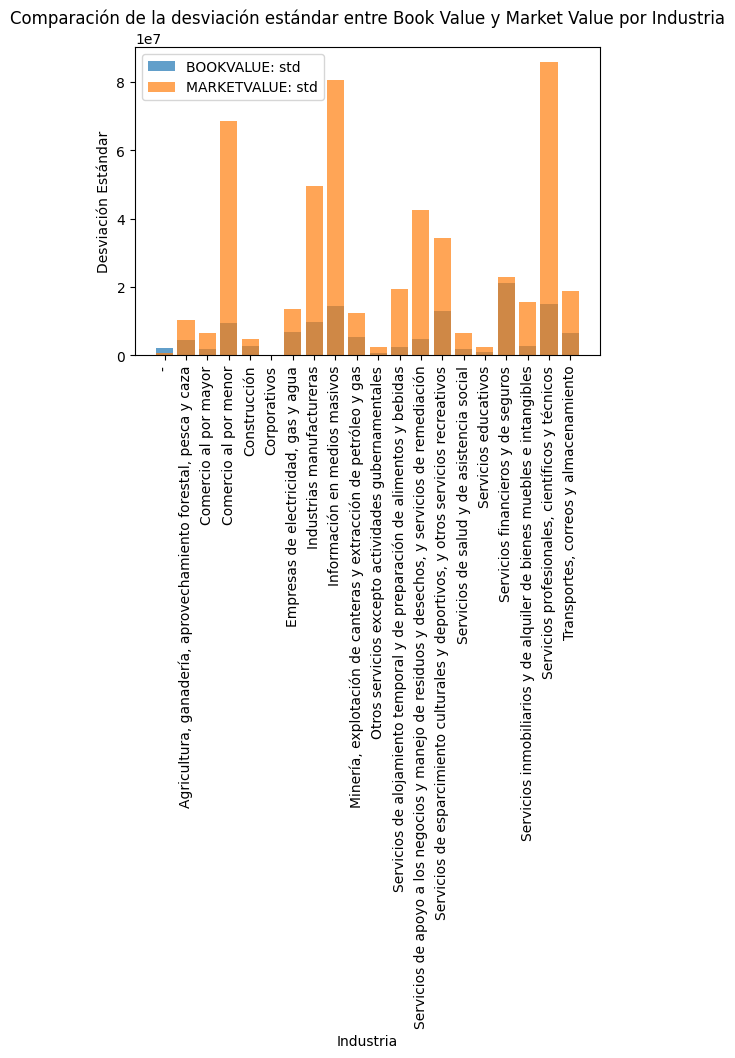

In [793]:
# Calcular la desviación estándar de BOOKVALUE y MARKETVALUE por industria
bookvalue_std = data.groupby('industria')['BOOKVALUE'].std().reset_index()
marketvalue_std = data.groupby('industria')['MARKETVALUE'].std().reset_index()

# Renombrar las columnas para diferenciarlas
bookvalue_std = bookvalue_std.rename(columns={'BOOKVALUE': 'BOOKVALUE_std'})
marketvalue_std = marketvalue_std.rename(columns={'MARKETVALUE': 'MARKETVALUE_std'})

# Unir ambas desviaciones estándar en un df para graficar
statistics_std = pd.merge(bookvalue_std, marketvalue_std, on='industria')

# Crear la gráfica comparativa
plt.figure(figsize=(6, 4))
plt.bar(statistics_std['industria'], statistics_std['BOOKVALUE_std'], label='BOOKVALUE: std', alpha=0.7)
plt.bar(statistics_std['industria'], statistics_std['MARKETVALUE_std'], label='MARKETVALUE: std', alpha=0.7)
plt.xlabel('Industria')
plt.ylabel('Desviación Estándar')
plt.title('Comparación de la desviación estándar entre Book Value y Market Value por Industria')
plt.xticks(rotation=90)
plt.legend()
plt.show()


En la mayoría de las industrias, el Market Value mediano es bastante más alto que el Book Value mediano. Esto podría significar que el mercado suele valorar a las empresas más de lo que en verdad valen (BOOKVALUE). En otras palabras, el mercado tiende a sobrevalorar a las empresas, probablemente porque se espera que crezcan, tengan una buena reputación o generen ingresos futuros.

Cuando miramos la media de ambos valores (Market Value y Book Value), notamos que la media suele ser más alta que la mediana. Esto suele pasar porque hay algunas empresas muy grandes que hacen que la media suba, distorsionando un poco la realidad. Por eso, la mediana es generalmente una mejor medida para representar a la mayoría de las empresas, ya que no se ve tan afectada por esas pocas empresas enormes.

En términos de Market Value, el tamaño típico de una empresa muestra mucha variabilidad dentro de muchas industrias. Esto sugiere que hay grandes diferencias entre empresas, con algunas siendo mucho más grandes que otras en términos de valor de mercado.

Por otro lado, el Book Value es más uniforme entre las empresas de una misma industria, con menos variabilidad. Esto significa que las empresas son más parecidas en cuanto a su valor contable.

Entonces, mientras que el Market Value muestra grandes diferencias en el tamaño de las empresas, el Book Value es más consistente. Por ello, la mediana es una mejor medida para representar el tamaño típico de una empresa, ya que no se deja llevar tanto por esos valores extremos (outliers) y no se deja caer en sesgos.

**¿Cuánto cambian estas variables dentro de cada industria? :**


El Market Value presenta una gran variabilidad dentro de muchas industrias, lo cual se evidencia en las altas desviaciones estándar observadas en las gráficas. Esta variabilidad sugiere que, dentro de la misma industria, los valores de mercado de las empresas pueden fluctuar considerablemente, con algunas empresas alcanzando valores de mercado muy altos mientras que otras se mantienen en niveles mucho más bajos. Esta notable dispersión puede distorsionar el promedio, haciendo que la media no sea un reflejo preciso del tamaño típico de las empresas en la industria. Por ello, la mediana surge como una medida estadística mejor y representativa para describir el valor de mercado de la mayoría de las empresas, al ser menos sensible a la influencia de estos valores extremos.

Por otro lado, el Book Value muestra una menor variabilidad entre las industrias, lo que se traduce en desviaciones estándar mucho más bajas en comparación con el Market Value. Esto indica que los valores contables de las empresas son más homogéneos, con menos dispersión alrededor de la media. Dado que el Book Value de las empresas dentro de una industria tiende a estar más concentrado, la mediana sigue siendo una representación adecuada para describir el valor contable típico, ya que minimiza la influencia de cualquier empresa con un valor contable excepcionalmente alto o bajo.

Por lo tanto, aunque ambas variables presentan cambios dentro de cada industria, la variabilidad es más pronunciada en el Market Value que en el Book Value. Esto refuerza la necesidad de utilizar la mediana como una medida central más representativa en ambos casos, en especial para el Market Value, donde las diferencias entre empresas pueden ser más extremas.

**¿Cómo se distribuye el tamaño de la empresa (en valor de mercado)?**

La distribución del tamaño de las empresas, en términos de Market Value, muestra una considerable variabilidad dentro de muchas industrias. Esta variabilidad se refleja en la notable diferencia entre la media, la mediana y la alta desviación estándar observadas en los datos. La presencia de un sesgo positivo (a la derecha) indica que, aunque la mayoría de las empresas en cada industria tienen un valor de mercado relativamente bajo, ya que, existen algunas empresas con valores de mercado significativamente mayores, lo que eleva la media por encima de la mediana.

Dado este sesgo, la mediana surge como una medida más representativa del tamaño típico de las empresas dentro de cada industria, ya que es menos susceptible a la influencia de estos valores atípicos que distorsionan la media. Por lo tanto, al analizar el tamaño de las empresas, es preferible utilizar la mediana para obtener una visión más precisa y menos sesgada de la distribución del Market Value en cada sector.

3. ¿Cuáles son las 10 empresas estadounidenses más grandes en términos de valor de mercado y qué tan lejos están del tamaño de mercado típico de una empresa estadounidense?

In [794]:
# Ordenar las empresas por valor de mercado en orden descendente y agrupándolas por empresa (para que no se repitan empresas)
first_10_companies = data.groupby('Empresa')['MARKETVALUE'].sum().sort_values(ascending=False).head(10)

# Tomar los nombres de las primeras 10 empresas
first_10_names = first_10_companies.index

# Filtrar las primeras 10 empresas
first_10_data = data[data['Empresa'].isin(first_10_names)]

# Hacer una tabla con los nombres de las 10 empresas, su industria y su suma de Market value
result = first_10_data.groupby('Empresa').agg({'industria': 'first', 'MARKETVALUE': 'sum'}).sort_values('MARKETVALUE', ascending=False)

# Imprimir las empresas
print(result)


                                                                industria  \
Empresa                                                                     
Apple Inc                                       Industrias manufactureras   
Microsoft Corp                              Información en medios masivos   
Alphabet Inc              Servicios profesionales, científicos y técnicos   
Amazon.Com, Inc                                     Comercio al por menor   
Exxon Mobil Corp                                Industrias manufactureras   
Walmart Inc                                         Comercio al por menor   
Johnson & Johnson                               Industrias manufactureras   
General Electric Company                        Industrias manufactureras   
Meta Platforms, Inc       Servicios profesionales, científicos y técnicos   
Jpmorgan Chase & Co                    Servicios financieros y de seguros   

                           MARKETVALUE  
Empresa                           

In [795]:
# Sumar todos los Market Values de todas las empresas
company_market_values = data.groupby('Empresa')['MARKETVALUE'].sum()
# Calcular el tamaño típico del mercado (con la mediana y no la media porque la media posee muchos outliers, es decir, desviación estándar)
median_market_value = company_market_values.median()
print('Tamaño típico del mercado:', median_market_value)

Tamaño típico del mercado: 34997992.625555396


In [796]:
# Distancia entre el tamaño de mercado típico y el Market Value del top 10 empresas
first_10_companies['distance_from_median'] = first_10_companies - median_market_value
print(first_10_companies['distance_from_median'])

Empresa
Apple Inc                   6.968498e+10
Microsoft Corp              6.807201e+10
Alphabet Inc                4.734901e+10
Amazon.Com, Inc             4.007766e+10
Exxon Mobil Corp            3.377943e+10
Walmart Inc                 2.542652e+10
Johnson & Johnson           2.501088e+10
General Electric Company    2.361824e+10
Meta Platforms, Inc         2.306267e+10
Jpmorgan Chase & Co         2.154043e+10
Name: MARKETVALUE, dtype: float64


In [797]:
# Calcular la diferencia
first_10_companies['percentage_difference'] = ((first_10_companies - median_market_value) / median_market_value) 
print(first_10_companies['percentage_difference'])

Empresa
Apple Inc                                                         1991.113744
Microsoft Corp                                                    1945.026045
Alphabet Inc                                                      1352.906426
Amazon.Com, Inc                                                   1145.141538
Exxon Mobil Corp                                                   965.181993
Walmart Inc                                                        726.513811
Johnson & Johnson                                                  714.637545
General Electric Company                                           674.845539
Meta Platforms, Inc                                                658.971147
Jpmorgan Chase & Co                                                615.476192
distance_from_median        Empresa
Apple Inc                   1990.11374...
Name: MARKETVALUE, dtype: object


Al analizar las 10 empresas estadounidenses más grandes en términos de valor de mercado, vemos que están en una liga totalmente distinta comparadas con el tamaño típico de una empresa en el mercado. Por ejemplo, Apple tiene un valor de mercado que es casi 2,000 veces mayor que la mediana del mercado. Esto demuestra que estas empresas, como Apple, Microsoft y Alphabet, concentran una parte enorme del valor total del mercado, lo que refleja una alta concentración y desigualdad.

El hecho de que estas empresas estén tan por encima de la mediana también resalta la importancia de usar la mediana como una mejor medida para representar el tamaño típico de una empresa, porque la media estaría completamente distorsionada por estas gigantes. Además, aunque estas empresas provienen de diferentes industrias, todas comparten la característica de tener un valor de mercado extremadamente alto en comparación con la mayoría de las otras empresas, lo que indica que dentro de sus industrias, son las líderes.

Es por eso que, estas 10 empresas están tan alejadas del tamaño de mercado típico que prácticamente operan en su propio espacio, lo que muestra un mercado muy concentrado donde unas pocas gigantes dominan.Las empresas con un mayor Market Value están alejadas de un 615 hasta un 1991 veces del tamaño típico de una empresa en US (lo cual, es demasiado), por lo que podemos decir que estas son las empresas que forman parte de los outliers de la distribución de MARKETVALUE.

4. ¿Cuáles son las 10 empresas estadounidenses más grandes en términos de valor contable y qué tan lejos están del tamaño contable típico de una empresa estadounidense?

In [798]:
# Ordenar las empresas por Book value en orden descendente y agrupándolas por empresa (para que no sea repitan empresas)
first_10_book = data.groupby('Empresa')['BOOKVALUE'].sum().sort_values(ascending=False).head(10)

# Tomar los nombres de las primeras 10 empresas
first_10_names_book = first_10_book.index

# Filtrar las primeras 10 empresas
first_10_data_book = data[data['Empresa'].isin(first_10_names_book)]

# Hacer una tabla con los nombres de las 10 empresas, su industria y su suma de book value
result_book = first_10_data_book.groupby('Empresa').agg({'industria': 'first', 'BOOKVALUE': 'sum'}).sort_values('BOOKVALUE', ascending=False)

# Imprimir las empresas
print(result_book)

                                                                industria  \
Empresa                                                                     
Berkshire Hathaway Inc                 Servicios financieros y de seguros   
Bank Of America Corp                   Servicios financieros y de seguros   
Jpmorgan Chase & Co                    Servicios financieros y de seguros   
Citigroup Inc                          Servicios financieros y de seguros   
Exxon Mobil Corp                                Industrias manufactureras   
Wells Fargo & Company                  Servicios financieros y de seguros   
Chevron Corp                                    Industrias manufactureras   
AT&T Inc                                    Información en medios masivos   
Alphabet Inc              Servicios profesionales, científicos y técnicos   
General Electric Company                        Industrias manufactureras   

                             BOOKVALUE  
Empresa                           

In [799]:
# Sumar todos los Book Values de todas las empresas
company_book_values = data.groupby('Empresa')['BOOKVALUE'].sum()
# Calcular el tamaño típico del mercado (con la mediana y no la media porque la media posee muchos outliers, es decir, desviación estándar)
median_book_value = company_book_values.median()
print('Tamaño típico del mercado:', median_book_value)

Tamaño típico del mercado: 11830299.0


In [800]:
# Distancia entre el tamaño de mercado típico y el Book Value del top 10 empresas
first_10_book['distance_from_median'] = first_10_book - median_book_value
print(first_10_book['distance_from_median'])

Empresa
Berkshire Hathaway Inc      2.166258e+10
Bank Of America Corp        1.915877e+10
Jpmorgan Chase & Co         1.785957e+10
Citigroup Inc               1.578566e+10
Exxon Mobil Corp            1.416238e+10
Wells Fargo & Company       1.211942e+10
Chevron Corp                1.025700e+10
AT&T Inc                    1.009984e+10
Alphabet Inc                9.293003e+09
General Electric Company    8.575766e+09
Name: BOOKVALUE, dtype: float64


In [801]:
# Calcular diferencia
first_10_book['percentage_difference'] = ((first_10_book - median_book_value) / median_book_value) 
print(first_10_book['percentage_difference'])


Empresa
Berkshire Hathaway Inc                                            1831.109991
Bank Of America Corp                                              1619.466482
Jpmorgan Chase & Co                                               1509.646772
Citigroup Inc                                                     1334.341905
Exxon Mobil Corp                                                  1197.127537
Wells Fargo & Company                                             1024.438833
Chevron Corp                                                        867.01069
AT&T Inc                                                           853.726241
Alphabet Inc                                                       785.525622
General Electric Company                                           724.898475
distance_from_median        Empresa
Berkshire Hathaway Inc      1830.10999...
Name: BOOKVALUE, dtype: object


Al observar las 10 empresas estadounidenses más grandes en términos de valor contable (Book Value), queda claro que, al igual que con el valor de mercado, estas empresas están significativamente por encima del tamaño contable típico de una empresa estadounidense. Por ejemplo, Berkshire Hathaway tiene un valor contable que es aproximadamente 1831 veces mayor que la mediana del valor contable en el mercado. Esto indica que estas empresas poseen una cantidad de activos netos muy superior al promedio, lo que las coloca en una posición destacada dentro del mercado.

La mayoría de las empresas en esta lista pertenecen al sector de servicios financieros y de seguros, lo que puede decir que en esta industria se concentran empresas con activos muy grandes en comparación con otras industrias. 

Al igual que con el Market Value, la gran diferencia entre la mediana del valor contable y los valores de las empresas más grandes resalta la presencia de outliers significativos en el mercado. Esto reitera la importancia de utilizar la mediana como una medida más representativa del tamaño típico de una empresa, ya que la media sería muy influenciada por estos valores extremos.

Es por eso que, las 10 empresas más grandes en términos de valor contable están a una distancia muy grande del tamaño típico de las empresas en el mercado estadounidense. Esto refleja una gran concentración de activos en unas pocas empresas, especialmente en el sector financiero.

### 1.3 Evolución del mercado financiero de US
Considerando el historial completo de datos financieros de todas las empresas, y solo la información fiscal anual (seleccionando mes fiscal = 12):

1. ¿Cómo ha cambiado el valor total del mercado estadounidense a lo largo de los años? Haz una tabla y/o gráfica y explica:



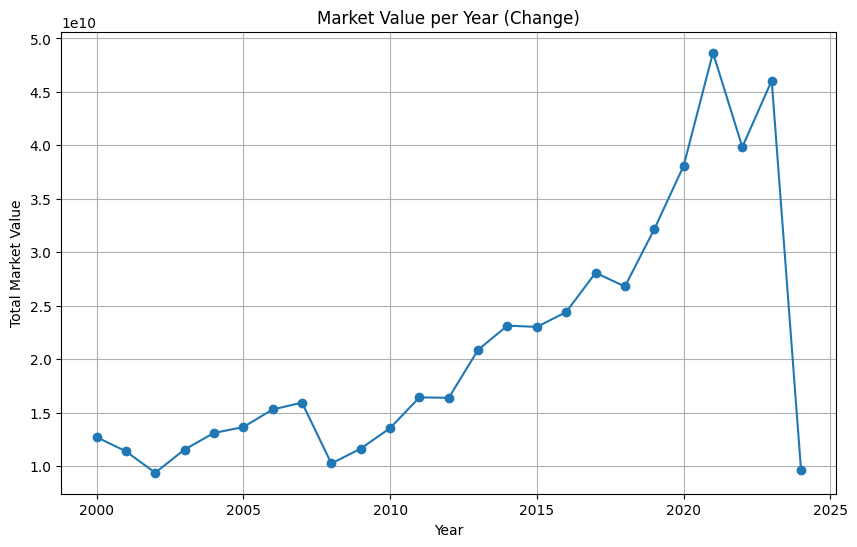

In [802]:
# Filtrar la información por año fiscal (cuando el mes sea 12)
data_per_year = data[data['fiscalmonth'] == 12]

# Calcular el MARKETVALUE total para cada año
total_market_value_per_year = data_per_year.groupby('year')['MARKETVALUE'].sum()

# Tabla por año de MKT Value
mkt_val_by_year = total_market_value_per_year.reset_index()
mkt_val_by_year.columns = ['Year', 'Market Value']

plt.figure(figsize=(10, 6))
plt.plot(mkt_val_by_year['Year'], mkt_val_by_year['Market Value'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Market Value')
plt.title('Market Value per Year (Change)')
plt.grid(True)
plt.show()


Esta gráfica nos cuenta la trayectoria de cómo ha cambiado el valor total del mercado estadounidense a lo largo de los años. Desde el 2000 hasta 2021, podemos ver un crecimiento bastante constante en el valor del mercado. Aunque hubo algunas caídas y subidas pequeñas, la tendencia general fue hacia arriba, lo que muestra un mercado en expansión, con empresas cada vez más costosas.

En 2021, el mercado alcanzó un pico importante, probablemente impulsado por el auge de las empresas tecnológicas (debido a la pandemia y la digitalización de los negocios) y otros factores. Sin embargo, después de este pico, hay una caída bastante drástica, especialmente hacia 2024. Esta caída podría deberse a una corrección del mercado, problemas económicos o cambios en las políticas que afectaron el valor de las empresas.

La gráfica también destaca períodos de estabilidad, como entre 2010 y 2015, donde el crecimiento fue más moderado, reflejando un mercado más estable durante esos años.

En resumen, el valor total del mercado estadounidense creció de manera sólida durante dos décadas, alcanzó su punto más alto en 2021, pero luego experimentó una caída significativa, recordándonos lo volátil que puede ser el mercado financiero.

2. ¿Cómo han cambiado a lo largo de los años los ingresos totales y los ingresos netos totales de todas las empresas estadounidenses? Haz una tabla y/o gráfica y explica

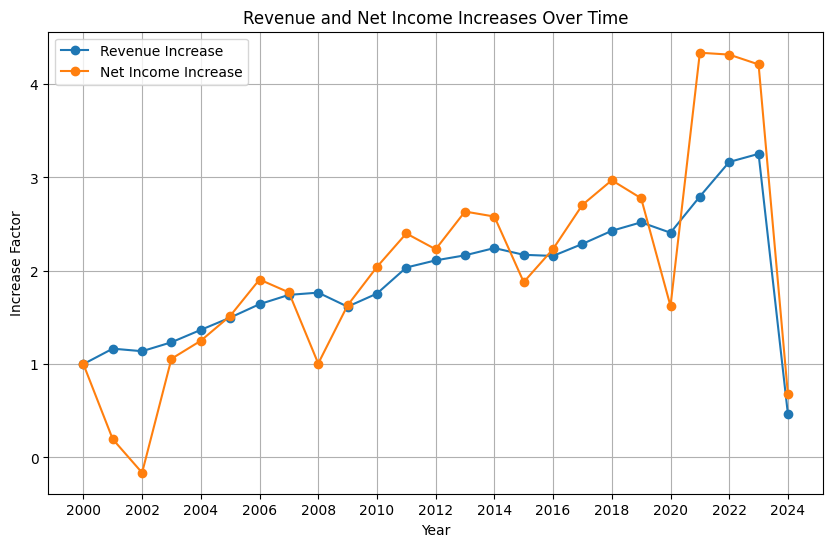

In [803]:
# Calcular el factor de incremento dividiendo cada valor por el primer valor de cada columna
total_revenue_per_year = data_per_year.groupby('year').agg({'revenue': 'sum', 'NETINCOME': 'sum'}).reset_index()
total_revenue_per_year.columns = ['Year', 'Revenue', 'Net Income']
mkt_val_by_year['Market Value Increase'] = mkt_val_by_year['Market Value'] / mkt_val_by_year.iloc[0]['Market Value']
total_revenue_per_year['Revenue Increase'] = total_revenue_per_year['Revenue'] / total_revenue_per_year.iloc[0]['Revenue']
total_revenue_per_year['Net Income Increase'] = total_revenue_per_year['Net Income'] / total_revenue_per_year.iloc[0]['Net Income']

# Graficar los factores de incremento
plt.figure(figsize=(10, 6))
plt.plot(total_revenue_per_year['Year'], total_revenue_per_year['Revenue Increase'], marker='o', linestyle='-', label='Revenue Increase')
plt.plot(total_revenue_per_year['Year'], total_revenue_per_year['Net Income Increase'], marker='o', linestyle='-', label='Net Income Increase')
plt.xlabel('Year')
plt.ylabel('Increase Factor')
plt.title('Revenue and Net Income Increases Over Time')
plt.legend()

# Ajustar los ticks del eje x para mostrar solo cada dos años
plt.xticks(mkt_val_by_year['Year'][::2])

plt.grid(True)
plt.show()


A lo largo de los años, tanto los ingresos totales como los ingresos netos de las empresas estadounidenses han etnido cambios significativos. En general, ambos han mostrado un crecimiento sostenido desde el año 2000, lo que refleja un desempeño financiero positivo en el mercado.

Sin embargo, los ingresos netos han sido mucho más volátiles que los ingresos totales. Por ejemplo, en los primeros años, se puede ver que los ingresos netos cayeron considerablemente antes de volver a subir. Esta fluctuación sugiere que factores como cambios en costos, impuestos, o ganancias excepcionales han tenido un impacto más fuerte en las ganancias netas de las empresas.

Un gran punto a considerar es el aumento significativo en los ingresos netos alrededor de 2021, que incluso superó al incremento en los ingresos totales. Este pico podría haber sido impulsado por cambios en costos, activos, o cambios causados por la pandemia y su notable reducción de costos operativos y de packaging, a pesar de que los ingresos generales no crecieran al mismo ritmo.

Sin embargo, después de 2021, tanto los ingresos totales como los ingresos netos comenzaron a disminuir de manera notable, llegando a niveles cercanos a los del año 2000 hacia 2024. Esta caída podría estar relacionada con alguna crisis económica derivada al regreso de la pandemia así como que para el 2024 aún no tenemos los datos completos porque aún no termina.

### 1.4 Aprender sobre una industria

Industria seleccionada: Manufacturing industries

#### 1.4.1 Estadísticas descriptivas para su industria
Usando la submuestra de la industria "Manufacturing industries" y usando información fiscal anual (seleccionando filas con mes fiscal = 12) y el año completo más reciente (2023), haga lo siguiente:

- Muestre estadísticas descriptivas para el rendimiento de registro anual futuro, activos totales, ingresos, ingresos netos, variables de control y todos los índices financieros seleccionados. Proporcionar una interpretación clara de las estadísticas descriptivas de ingresos y 1 ratio financiero.

In [804]:
# Filtrar empresas manufactureras por industria en año fiscal
manuf_industry = data[(data['industria'] == 'Industrias manufactureras') &
                      (data['fiscalmonth'] == 12) &
                      (data['year'] == 2023)
]

# Select features
selected_features = ['return_y_future', 'totalassets', 'revenue', 'MARKETVALUE', 'BOOKVALUE', 'NETINCOME', 'ROE', 'NPM', 'ROIC', 'OPM', 'DEBTTOEQUITY', 'CURRENTRATIO', 'NOPAT', 'EBIT', 'BOOKMARKET', 'currentassets', 'currentliabilities', 'EPSP', 'totalliabilities']

man_ind = manuf_industry[selected_features]

# Descriptive statistics
statistics = man_ind.describe()
print(statistics.round(2))

       return_y_future   totalassets       revenue   MARKETVALUE  \
count           179.00  1.471000e+03  1.471000e+03  1.414000e+03   
mean             -0.05  6.844456e+06  4.656406e+06  1.337376e+07   
std               0.70  2.551226e+07  1.973081e+07  8.527483e+07   
min              -3.24  4.360000e+00 -2.850820e+03  3.842900e+02   
25%              -0.31  9.825300e+04  8.564000e+03  8.802495e+04   
50%               0.09  5.046920e+05  2.687200e+05  7.105686e+05   
75%               0.34  2.732000e+06  2.222889e+06  4.287962e+06   
max               1.42  3.763170e+08  3.832850e+08  2.676737e+09   

          BOOKVALUE    NETINCOME      ROE       NPM     ROIC       OPM  \
count  1.471000e+03      1468.00  1468.00   1272.00  1467.00   1272.00   
mean   2.599635e+06    420341.30    -0.64    -55.30    -0.34    -42.90   
std    1.043731e+07   3246573.63    10.54    916.62     0.92    545.59   
min   -1.722800e+07  -6995000.00  -205.42 -31028.75   -13.08 -16785.75   
25%    2.843750e+

In [805]:
# Calcular promedio ponderado (Sum de Numerador / Sum de Denominador)
weighted_avg_roe = man_ind['NETINCOME'].sum() / man_ind['BOOKVALUE'].sum()
weighted_avg_npm = man_ind['NETINCOME'].sum() / man_ind['revenue'].sum()
weighted_avg_roic = man_ind['NOPAT'].sum() / man_ind['totalassets'].sum()
weighted_avg_opm = man_ind['EBIT'].sum() / man_ind['revenue'].sum()
weighted_avg_d2e = man_ind['totalliabilities'].sum() / man_ind['BOOKVALUE'].sum()
weighted_avg_cr = man_ind['currentassets'].sum() / man_ind['currentliabilities'].sum()

print(f"Promedio Ponderado ROE: {weighted_avg_roe:.4f}")
print(f"Promedio Ponderado NPM: {weighted_avg_npm:.4f}")
print(f"Promedio Ponderado ROIC: {weighted_avg_roic:.4f}")
print(f"Promedio Ponderado OPM: {weighted_avg_opm:.4f}")
print(f"Promedio Ponderado Debt to Equity: {weighted_avg_d2e:.4f}")
print(f"Promedio Ponderado Current Ratio: {weighted_avg_cr:.4f}")

Promedio Ponderado ROE: 0.1614
Promedio Ponderado NPM: 0.0901
Promedio Ponderado ROIC: 0.0629
Promedio Ponderado OPM: 0.1145
Promedio Ponderado Debt to Equity: 1.6329
Promedio Ponderado Current Ratio: 1.4533


- El promedio ponderado del ROE dice que en promedio, las empresas manufactureras están generando un retorno del 16.14% sobre su patrimonio neto, lo cual, es bastante bueno, pues indica que las empresas en esta industria usan eficientemente su capital para generar beneficios. La media del ROE es -0.64, es negativa, así que sugiere que la mayoría de las empresas poseen pérdidas en vez de beneficios. Por otro lado, su mediana es 0, por lo que sugiere que la mayoría de las empresas tienen ROEs cercanos a 0, es decir, que apenas generan beneficios a partir de su patrimonio.
- El promedio ponderado de NPM nos dice que en promedio, las empresas manufactureras obtienen un beneficio de 9 centavos por cada dólar que se ingresa. Esto indica que las empresas pueden obtener una rentabilidad razonable después de cubrir sus gastos. Su media es -55.30, es negativa, así que sugiere que la mayoría de las empresas no obtienen beneficios después de cubrir sus costos. Su mediana es 0, lo que indicaría que la mayoría de las empresas están tienen dificultades para obtener beneficios después de cubrir sus costos.
- El promedio ponderado de ROIC indica que  por cada dólar de capital invertido, las empresas manufactureras generan un retorno de 6.29 centavos por cada dólar invertido. La media es -0.34, podemos ver que es negativa, indicando que las empresas no logran generar gran valor sobre el capital invertido. La mediana es -0.03, indicando que la mayoría de las empresas están teniendo rendimientos bajos o nulos sobre el capital invertido.
- El promedio ponderado de OPM dice que las empresas están teniendo un beneficio operativo de 11.45 centavos por dólar de ingresos antes de considerar intereses e impuestos, lo que sugiere que las operaciones manufactureras son algo eficientes. La media es -42.90, es negativa, por lo cual indica que la mayoría de las empresas operan con pérdidas. La mediana es 0.02, es positiva, por lo que indica que muchas de las empresas operan apenas con lo necesario indicando incluso un poco de ineficiencia, al ser un número muy bajo.
- El promedio ponderado de DEBTTOEQUITY dice que las empresas tienen una relación deuda-patrimonio de 1.6329. Esto significa que, por cada dólar de capital propio, las empresas están financiando aproximadamente 1.63 dólares con deuda. Un valor como este sugiere que las empresas están recurriendo a la deuda para financiar sus operaciones y crecimiento en una proporción que es razonable, pero que también puede conllevar un riesgo financiero si las condiciones económicas empeoran. Sin embargo, al observar la media simple de Debt to Equity, que es -0.22, podemos ver una gran diferencia, lo que sugiere que muchas de las empresas tienen una relación negativa o baja, indicando pérdidas netas en términos de patrimonio en comparación con su deuda. La mediana es 2e+05, lo que indica que muchas de las empresas manufactureras tienen un alto nivel de endeudamiento, financiando principalmente con deuda. Esto sugiere que, aunque algunas empresas tienen ratios de deuda manejables, una parte considerable de las empresas en la industria se apalancan fuertemente, lo cual podría implicar riesgos financieros importantes si no logran generar los ingresos necesarios para cubrir sus deudas.
- El promedio ponderado del Current Ratio es 1.4533, lo que indica que, en promedio, las empresas manufactureras tienen aproximadamente 1.45 veces más activos a corto plazo que pasivos a corto plazo. Esto sugiere que las empresas están en una posición razonablemente sólida para cumplir con sus obligaciones a corto plazo, aunque no es un nivel extremadamente alto que garantice una amplia liquidez. La media es 4.41, lo que sugiere que algunas empresas pueden estar manteniendo niveles extremadamente altos de activos a corto plazo en comparación con sus pasivos, lo que podría distorsionar el resultado general. La mediana es 0.02, lo que muestra que una gran parte de las empresas tienen niveles muy bajos de liquidez en relación con sus pasivos a corto plazo. Podría ser indicativo de empresas que enfrentan dificultades para pagar sus deudas inmediatas o que están operando con un alto riesgo de insolvencia a corto plazo.

Con esto en mente, podemos concluir con que los promedios ponderados son significativamente más altos que las medias simples de los ratios, por lo que podemos intuir que las empresas más grandes logran mejores resultados financieros que las empresas pequeñas. Por otro lado, la mediana muestra que muchas de las empresas de la industria manufacturera tienen dificultades financieras, con márgenes operativos y retornos negativos en comparación con el capital. Por ello, el promedio ponderado de todos los ratios es la medida más adecuada para los finantial ratios, pues se muetra el alto impacto de las industrias comparado con el bajo impacto de las industrias pequeñas, dando una visión más clara del desempeño de la industria manufacturera.

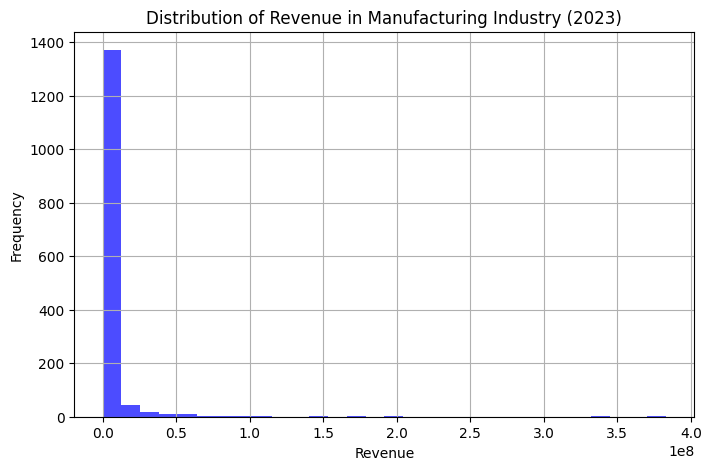

In [806]:
# Revenue
plt.figure(figsize=(8, 5))
plt.hist(man_ind['revenue'].dropna(), bins=30, color='blue', alpha=0.7)
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.title('Distribution of Revenue in Manufacturing Industry (2023)')
plt.grid(True)
plt.show()

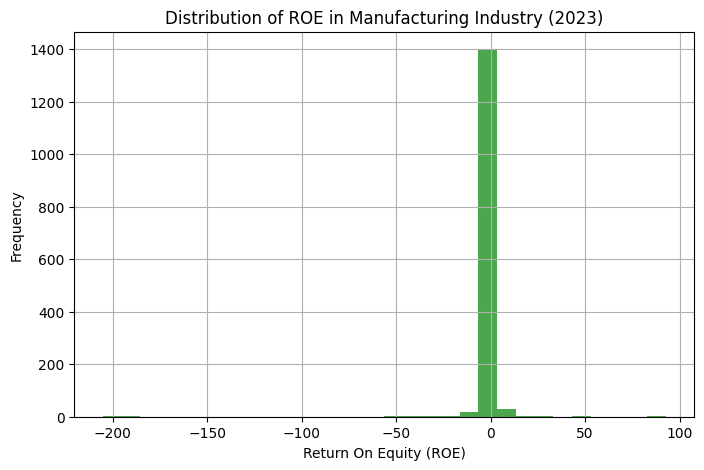

In [807]:
# ROE
plt.figure(figsize=(8, 5))
plt.hist(man_ind['ROE'].dropna(), bins=30, color='green', alpha=0.7)
plt.xlabel('Return On Equity (ROE)')
plt.ylabel('Frequency')
plt.title('Distribution of ROE in Manufacturing Industry (2023)')
plt.grid(True)
plt.show()

**REVENUE**

La gráfica de distribución del revenue en la industria manufacturera para el 2023 muestra una distribución altamente sesgada a la derecha. La mayoría de las empresas en esta industria tienen ingresos significativamente bajos en comparación con las pocas que están en los rangos más altos. Este comportamiento se ve reflejado en las estadísticas descriptivas, donde la mediana del revenue es de aproximadamente $268,720, mientras que algunas empresas alcanzan hasta $383,285,000. La gran diferencia entre la mediana y las cifras más altas indica la presencia de algunas empresas muy grandes que sesgan la distribución.

Este tipo de distribución sugiere que la mayoría de las empresas en la industria manufacturera son pequeñas o medianas, mientras que solo unas pocas generan ingresos extremadamente altos, sesgando la media hacia valores superiores. Por esta razón, es más representativo utilizar la mediana para describir el comportamiento de la mayoría de las empresas en esta industria.

**ROE**

La gráfica del ROE (Retorno sobre el Patrimonio) muestra una distribución donde la gran mayoría de las empresas tienen un ROE cercano a 0, lo que indica que muchas no están generando ganancias significativas en relación con sus fondos propios, o incluso podrían estar operando con pérdidas. Los valores negativos de ROE reflejan posibles problemas financieros o pérdidas sustanciales dentro de la industria. Sin embargo, algunas empresas muestran ROEs considerablemente altos, lo que sugiere que están obteniendo retornos significativos sobre su capital.

En conclusión, la mayoría de las empresas manufactureras generan ingresos relativamente bajos y muestran un ROE bajo, lo que indica que operan con márgenes reducidos y enfrentan dificultades para obtener retornos significativos sobre su capital.


#### 1.4.2 Matriz de correlación

Utilizando datos fiscales anuales (seleccionando filas con mes fiscal = 12) y todos los años:

Muestre una matriz de correlación con las mismas variables que utilizó para las estadísticas descriptivas anteriores, pero en el caso de activos totales, ingresos e ingresos netos, utilice la transformación logarítmica de sus valores. ¿Qué variables tienen una relación lineal más fuerte y significativa con los rendimientos de las acciones (rendimientos anuales)? Explicar

In [808]:
# Aplicar transformación logarítmica a 'totalassets', 'revenue', 'NETINCOME'
# Poner un caso para cuando se trate de calcular log de 0 (que es indefinido)
man_ind['log_totalassets'] = np.log(man_ind['totalassets'].replace(0, np.nan))
man_ind['log_revenue'] = np.log(man_ind['revenue'].replace(0, np.nan))
man_ind['log_NETINCOME'] = np.log(man_ind['NETINCOME'].replace(0, np.nan))

selected_features_log = ['return_y_future', 'log_totalassets', 'log_revenue', 'MARKETVALUE', 'BOOKVALUE', 'log_NETINCOME', 'ROE', 'NPM', 'ROIC', 'OPM',  'DEBTTOEQUITY', 'CURRENTRATIO', 'BOOKMARKET', 'EPSP']
correlation_data = man_ind[selected_features_log].corr()
print(correlation_data.round(2))

                 return_y_future  log_totalassets  log_revenue  MARKETVALUE  \
return_y_future             1.00             0.28         0.32         0.14   
log_totalassets             0.28             1.00         0.87         0.29   
log_revenue                 0.32             0.87         1.00         0.26   
MARKETVALUE                 0.14             0.29         0.26         1.00   
BOOKVALUE                   0.07             0.44         0.37         0.47   
log_NETINCOME               0.01             0.88         0.87         0.37   
ROE                        -0.00             0.05         0.05         0.02   
NPM                         0.08             0.07         0.19         0.02   
ROIC                        0.39             0.54         0.52         0.08   
OPM                         0.08             0.08         0.24         0.02   
DEBTTOEQUITY               -0.03             0.01        -0.00         0.01   
CURRENTRATIO                0.02            -0.17   

C:\Users\marif\AppData\Local\Temp\ipykernel_7892\2154142328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  man_ind['log_totalassets'] = np.log(man_ind['totalassets'].replace(0, np.nan))
c:\Users\marif\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\marif\AppData\Local\Temp\ipykernel_7892\2154142328.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  man_

Text(0.5, 1.0, 'Correlation Matriz')

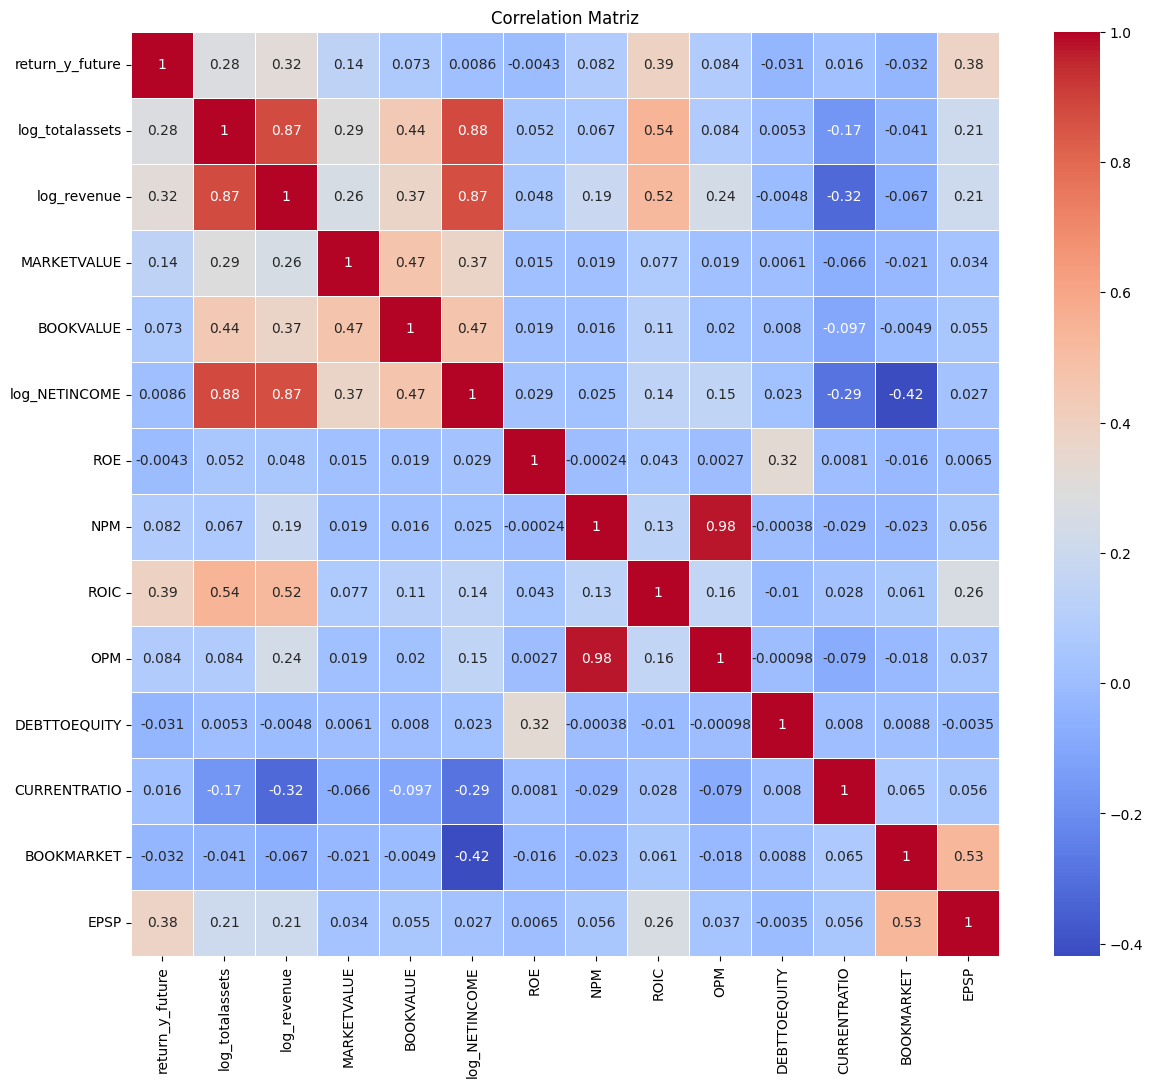

In [809]:
# Crear la matriz de correlación con seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matriz')


En una matriz de correlación, cuanto más cercana es la correlación a 1 o -1, más fuerte es la **relación lineal** (ojo, es relación lineal, puede que una x variable no presente una gran relación lineal con cierta variable, pero puede representar otro tipo de relación) entre dos variables. Una correlación cercana a 1 indica una relación positiva fuerte, mientras que una correlación cercana a -1 indica una relación negativa fuerte. Teniendo esto en cuenta, podemos analizar qué variables tienen la relación más significativa con los rendimientos anuales (return_y_future).

# Variables con mayor correlación positiva con los rendimientos futuros:
- ROIC (0.39): La variable con la correlación más fuerte y positiva con los rendimientos futuros es el ROIC (Retorno sobre el Capital Invertido), con una correlación de 0.39. Esto sugiere que las empresas más eficientes en generar retornos sobre su capital invertido tienden a tener mejores rendimientos en el mercado de acciones. Este hallazgo es consistente con la teoría, ya que el ROIC mide la capacidad de una empresa para convertir su capital en beneficios, lo que generalmente mejora su desempeño en el mercado de valores. Además, un alto ROIC indica que la empresa está utilizando su capital de manera eficiente, lo que es clave para el crecimiento y la competitividad a largo plazo.

- EPSP (0.38): El EPSP (Ganancias por Acción) también muestra una correlación positiva con los rendimientos futuros, lo que implica que las empresas que generan mayores ganancias por acción tienden a obtener mejores rendimientos en el mercado. Esto es lógico, ya que un EPSP elevado suele indicar una empresa rentable que está creando valor para sus accionistas, lo que a su vez impulsa la demanda de sus acciones y, por lo tanto, el rendimiento de las mismas.

# Variables con correlación negativa con los rendimientos futuros:
- log_revenue (-0.32): Existe una correlación negativa entre el logaritmo de los ingresos y los rendimientos futuros. Esto sugiere que, en la industria manufacturera, un mayor crecimiento en los ingresos no siempre se traduce en un mejor rendimiento en el mercado. Es posible que algunas empresas generen altos ingresos pero no logren convertirlos en beneficios operativos o financieros, lo que puede afectar su desempeño en el mercado de valores.

- log_totalassets (-0.28): De manera similar, la correlación negativa entre el logaritmo de los activos totales y los rendimientos futuros podría indicar que las empresas más grandes, con mayores activos, no están utilizando esos recursos de manera eficiente para generar valor en el mercado de acciones. Esto sugiere que las empresas manufactureras más grandes podrían estar enfrentando desafíos operativos o estructurales que afectan su capacidad para generar rendimientos.

# Variables con baja o nula correlación:
- ROE (-0.004): A pesar de ser una métrica común para medir la rentabilidad de una empresa, el ROE tiene una correlación extremadamente baja con los rendimientos futuros en este análisis. Esto sugiere que la rentabilidad sobre el patrimonio no está necesariamente vinculada al desempeño futuro de las acciones en este contexto específico. La baja correlación puede deberse a que el ROE está influenciado por la estructura de capital y otros factores internos que no necesariamente se reflejan en el valor de mercado.

- OPM (-0.084) y NPM (-0.082): Estas dos métricas de margen de beneficios operativos y netos también tienen correlaciones bajas con los rendimientos futuros. Aunque son indicadores importantes de la eficiencia operativa, parece que no son determinantes clave del rendimiento de las acciones en este análisis. Esto podría deberse a que los inversores no están considerando los márgenes operativos como un reflejo del potencial de crecimiento o rentabilidad a largo plazo.

- BOOKMARKET (-0.032) y MARKETVALUE (-0.14): Estas variables, que se utilizan comúnmente para evaluar la valoración de una empresa, muestran correlaciones bajas o negativas con los rendimientos futuros. Esto sugiere que en la industria manufacturera, el valor de mercado y el valor en libros no son indicadores significativos del rendimiento futuro de las acciones, al menos en este análisis.

#### 1.4.3 Modelo de regresión
Para cada ratio financiero, haga lo siguiente:
Hacer un histograma e interpretarlo.

Haga gráficos para visualizar la posible relación que podría tener cada factor con los rendimientos trimestrales (la variable dependiente).

Diseñe y ejecute una primera versión de un modelo de regresión múltiple para examinar si los índices seleccionados pueden explicar/predecir futuros rendimientos anuales de las acciones.

Debe comprobar posibles problemas de multicolinealidad. Explicar brevemente qué es la multicolinealidad, ejecutar e interpretar la prueba correspondiente.

Interpreta tu modelo

Interpreta con tus propias palabras los resultados de cada coeficiente (beta y su significancia estadística)

Interpretar el R cuadrado del modelo.

Escribe una conclusión de tus resultados.



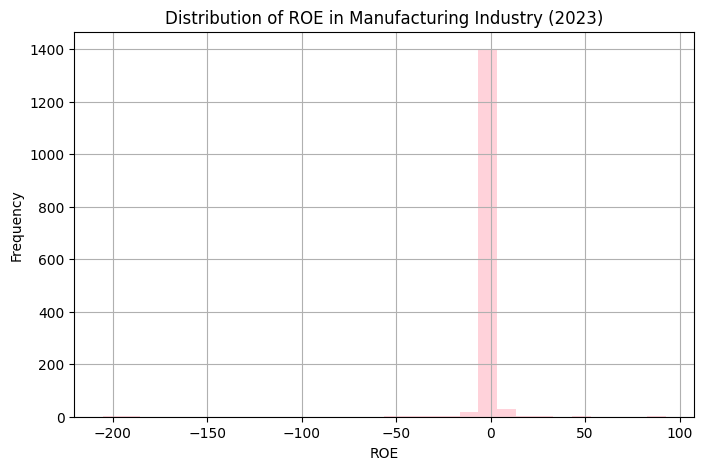

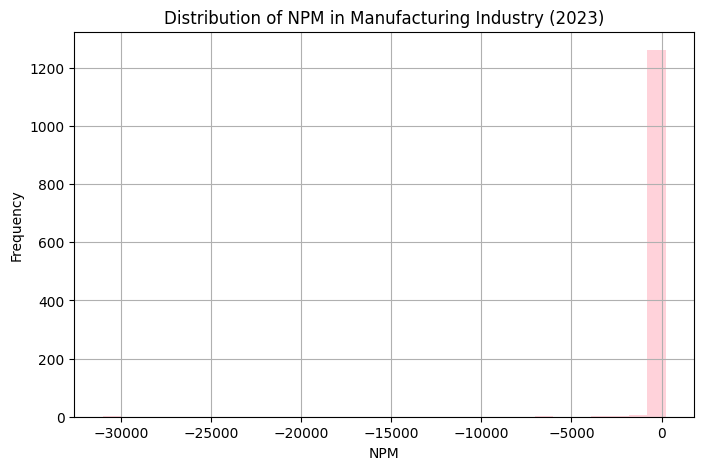

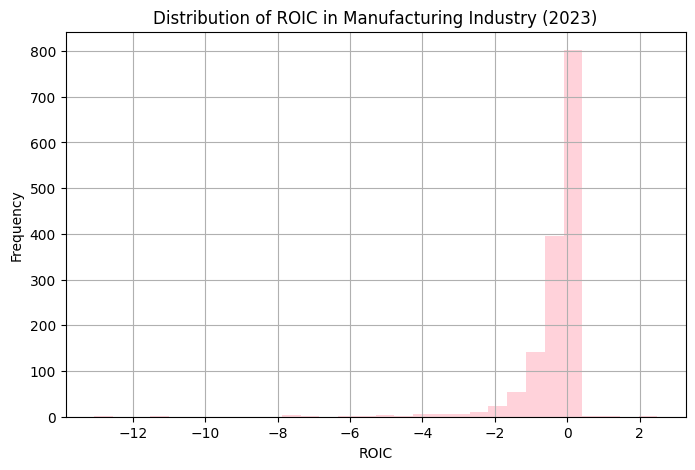

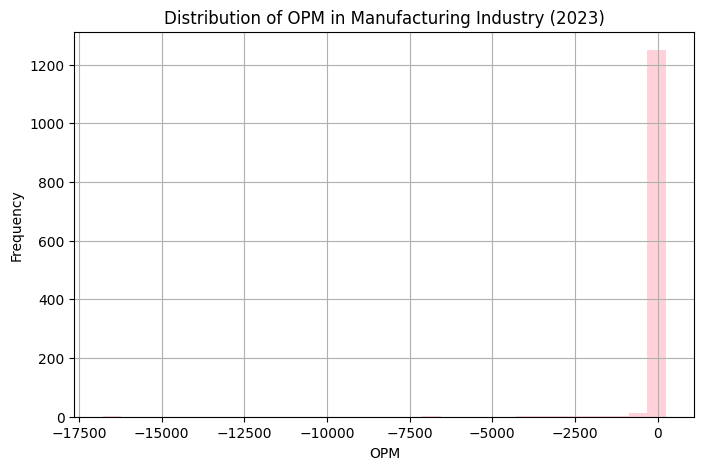

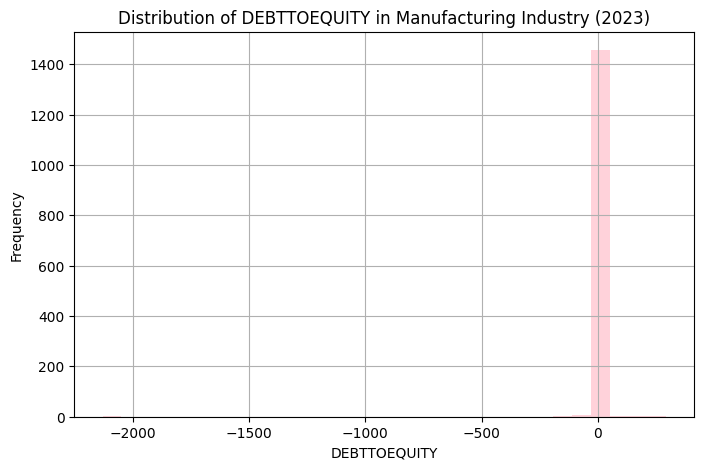

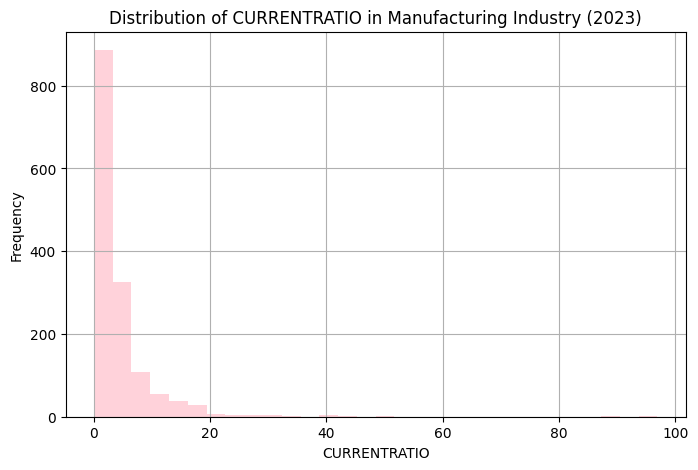

In [810]:
finantial_ratios = ['ROE', 'NPM', 'ROIC', 'OPM', 'DEBTTOEQUITY', 'CURRENTRATIO']

for ratio in finantial_ratios:
  plt.figure(figsize=(8, 5))
  # Reemplazar valores infinitos con nan
  valid_data = man_ind[ratio].replace([np.inf, -np.inf], np.nan)
  plt.hist(valid_data, bins=30, color='pink', alpha=0.7)
  plt.xlabel(ratio)
  plt.ylabel('Frequency')
  plt.title(f'Distribution of {ratio} in Manufacturing Industry (2023)')
  plt.grid(True)
  plt.show()

**Return on Equity**

La distribución del ROE muestra que la mayoría de las empresas en la industria manufacturera tienen un ROE cercano a 0. Esto indica que muchas empresas no están generando retornos significativos sobre su patrimonio, lo que puede sugerir que están teniendo dificultades para generar beneficios en relación con los fondos de los accionistas. Sin embargo, hay algunas empresas con ROEs extremos, tanto negativos como positivos, lo que sugiere que algunas están operando con pérdidas significativas, mientras que otras logran altos retornos.

**Net Profit Margin (NPM)**

El histograma del NPM presenta una gran concentración de valores negativos, con muchas empresas alcanzando márgenes de beneficio neto extremadamente bajos, incluso hasta -35,000%. Este sesgo hacia la izquierda indica que una gran parte de las empresas manufactureras están operando con pérdidas considerables, lo que refleja posibles problemas de eficiencia o altos costos operativos.

**Return on Invested Capital (ROIC)**

La distribución del ROIC está muy sesgada hacia el rango de valores negativos y cercanos a 0. Muchas empresas tienen un ROIC entre 0 y -2, lo que indica que no están generando los rendimientos esperados en relación con el capital invertido. Esta falta de eficiencia en el uso del capital sugiere que no se están optimizando los recursos para maximizar los beneficios.

**Operating Profit Margin (OPM)**

El OPM también muestra una distribución similar al NPM, con la mayoría de los valores en la parte negativa del histograma. Las empresas que tienen un OPM negativo están teniendo dificultades para convertir sus ingresos operativos en ganancias, lo que indica que sus operaciones básicas no son rentables. Un margen operativo negativo suele ser indicativo de altos costos operativos o baja demanda de productos o servicios.

**Debt to Equity (DEBTTOEQUITY)**

La distribución del ratio Debt to Equity muestra que la mayoría de las empresas tienen un nivel de endeudamiento en relación con el capital propio muy bajo, lo que indica un bajo endeudamiento financiero. Esto sugiere que muchas empresas en la industria manufacturera están financiando sus operaciones con capital propio en lugar de con deuda, lo que puede ser una señal de que las empresas prefieren no asumir altos riesgos financieros. Sin embargo, hay algunas empresas con valores de DEBTTOEQUITY extremadamente negativos, lo que sugiere que estas empresas tienen un alto nivel de deuda en comparación con su valor en libros, posiblemente debido a dificultades financieras o una alta dependencia del endeudamiento para financiar sus operaciones.

**Current Ratio (CURRENTRATIO)**

La distribución del Current Ratio en la industria manufacturera para el 2023 muestra que la mayoría de las empresas tienen un Current Ratio muy bajo, concentrándose en valores cercanos a 0. Esto indica que una gran cantidad de empresas tienen dificultades para cubrir sus obligaciones a corto plazo con sus activos corrientes. Este resultado podría reflejar una falta de liquidez en muchas empresas, lo que sugiere que no cuentan con suficientes activos disponibles para cubrir sus deudas a corto plazo. Sin embargo, hay algunas empresas con Current Ratios mucho más altos, que alcanzan hasta 100. Estos valores extremos indican que algunas compañías tienen una gran cantidad de activos líquidos en comparación con sus pasivos corrientes, lo que les da una amplia capacidad para cumplir con sus obligaciones a corto plazo.

En general, las empresas pelean por tener retornos positivos con sus operaciones, capital y capital invertido, por lo que puede indicar una época económica difícil.

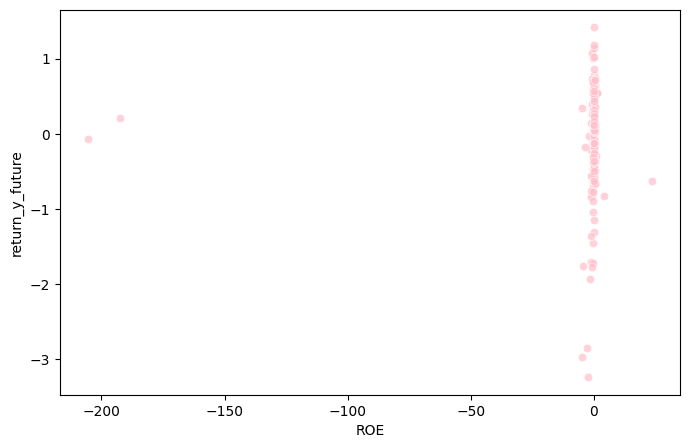

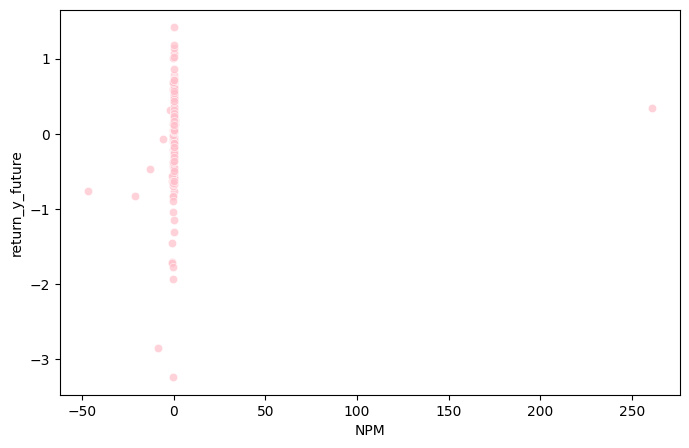

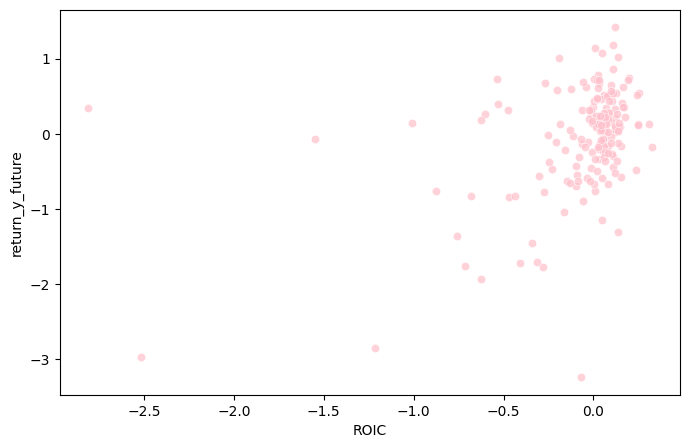

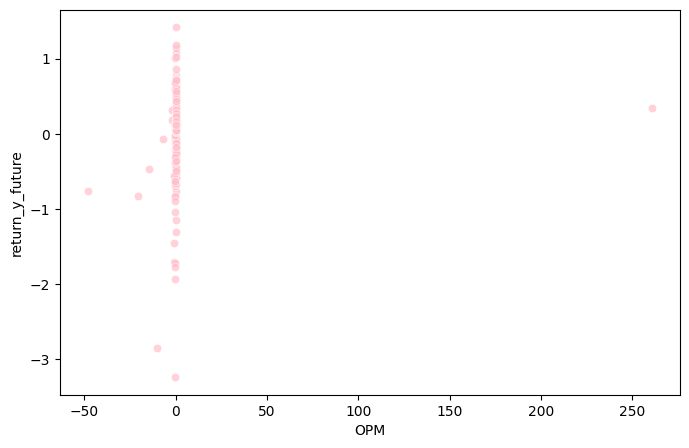

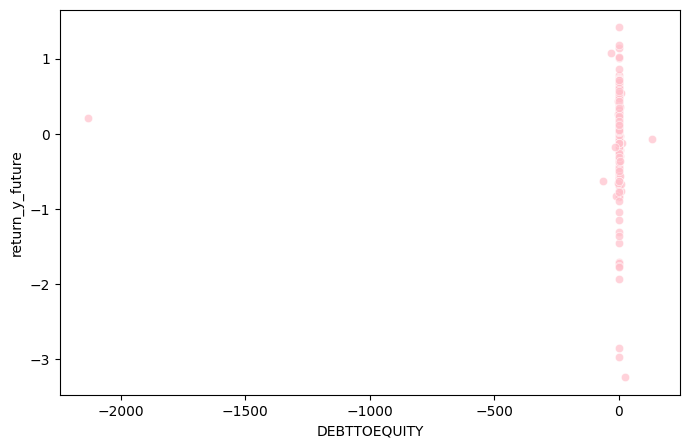

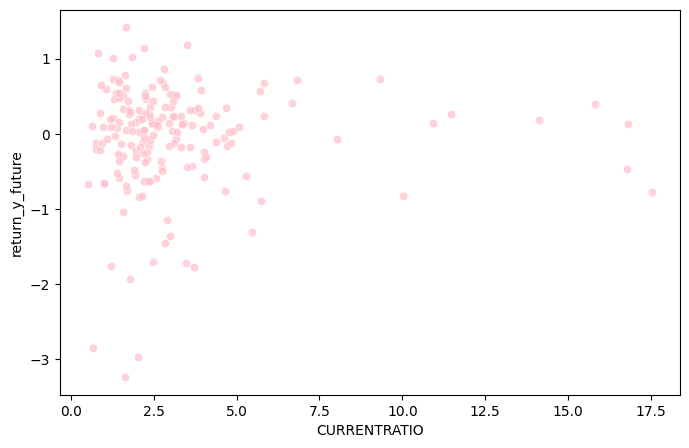

In [811]:
# Gráficas de relación: Ratios financiertos con rendimiento y futuro rendimiento
for ratio in finantial_ratios:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=ratio, y='return_y_future', data=man_ind, color='pink', alpha=0.7)
    plt.xlabel(ratio)
    plt.ylabel
    plt.show()


In [812]:
# MODELO BASE

# Asegurarnos de aplicar los mismos filtros desde el principio
filtered_data_inicial = data[(data['industria'] == 'Industrias manufactureras') & 
                            (data['fiscalmonth'] == 12)].copy()

# Seleccionar solo las variables necesarias para 'X' y 'y' a partir del conjunto filtrado inicial
X = filtered_data_inicial[['OPM', 'ROIC', 'CURRENTRATIO', 'DEBTTOEQUITY', 'EPSP', 'BOOKMARKET']].copy()
y = filtered_data_inicial['return_y_future'].copy()

# Guardar los índices originales
original_indices = X.index.copy()

# Reemplazar valores infinitos y NaNs con valores nulos en 'X'
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Añadir la constante para el modelo
X = sm.add_constant(X)

# Crear el modelo OLS, eliminando observaciones con valores faltantes
model = sm.OLS(y, X, missing='drop').fit()

# Imprimir el resumen del modelo base
print("Resumen del modelo base:")
print(model.summary())

Resumen del modelo base:
                            OLS Regression Results                            
Dep. Variable:        return_y_future   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     127.0
Date:                Fri, 06 Sep 2024   Prob (F-statistic):          2.71e-158
Time:                        21:46:00   Log-Likelihood:                -18025.
No. Observations:               19910   AIC:                         3.606e+04
Df Residuals:                   19903   BIC:                         3.612e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0296

In [813]:
# Obtener la matriz de influencia
influence = model.get_influence()

# Obtener los valores diagonales de la matriz hat (los leverages)
hat_matrix_diag = influence.hat_matrix_diag

# Definir un umbral común para identificar leverage points
k = X.shape[1] - 1      # número de predictores 
n = X.shape[0]          # número de observaciones
leverage_threshold = 2 * (k + 1) / n

# Identificar leverage points altos
high_leverage_points = np.where(hat_matrix_diag > leverage_threshold)[0]

# Identificar qué filas fueron eliminadas en missing = 'drop'
dropped_indices = original_indices.difference(X.index)

# Reinsertar las filas eliminadas como NaN en 'X' y 'y' para que cuadren con los índices originales
X_full = pd.DataFrame(index=original_indices, columns=X.columns)
X_full.update(X)  # Actualizar con los valores no eliminados
X_full.loc[dropped_indices] = np.nan  # Reinsertar las filas eliminadas con NaN

y_full = pd.Series(index=original_indices)
y_full.update(y)
y_full.loc[dropped_indices] = np.nan

# Winsorizar cada columna de las variables independientes de acuerdo a IQR
X_winsorized = X_full.copy()

for col in X_winsorized.columns:
    if col != 'const':                                          # No aplicar winsorización a la constante
        Q1 = np.percentile(X_winsorized[col].dropna(), 25)
        Q3 = np.percentile(X_winsorized[col].dropna(), 75)
        IQR = Q3 - Q1

        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        # Aplicar winsorización solo a los valores fuera de esos límites
        X_winsorized[col] = np.clip(X_winsorized[col], lower_limit, upper_limit)

# Asegurarnos de que no se eliminan filas y las columnas sean numéricas
X_winsorized = X_winsorized.apply(pd.to_numeric, errors='coerce')

# Aplicar interpolación solo a las columnas numéricas
X_winsorized.interpolate(inplace=True)

# 4. Crear el modelo OLS con los datos winsorizados
model_winsorized = sm.OLS(y_full.fillna(y_full.median()), X_winsorized, missing='drop').fit()

# Imprimir el resumen del modelo winsorizado
print("\nResumen del modelo winsorizado:")
print(model_winsorized.summary())


Resumen del modelo winsorizado:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     268.1
Date:                Fri, 06 Sep 2024   Prob (F-statistic):               0.00
Time:                        21:46:00   Log-Likelihood:                -22043.
No. Observations:               24369   AIC:                         4.410e+04
Df Residuals:                   24362   BIC:                         4.416e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          

**Leverages**

Los leverage points son observaciones que según su posición en el espacio de las VI, les otorga una mayor influencia sobre los valores predichos por el modelo. Se pueden identificar mediante la matriz hat, que es una matriz diagonal. Los valores de la matriz hat que son cercanos a 1 indican observaciones con un alto leverage, mientras que valores cercanos a 0 indican bajo leverage. 

En mi caso, identifiqué las observaciones que tienen un leverage alto utilizando el criterio de 2 x ((k+1)/ n), lo cual indica que esas observaciones están ejerciendo una mayor influencia sobre el ajuste del modelo.

Las observaciones que tienen valores extremos en las variables independientes, tienden a ser leverage points porque están alejadas del "centro" del resto de los datos. Esto les da más peso en la determinación de la línea de regresión, lo que puede distorsionar los coeficientes estimados si no se gestionan adecuadamente.

**Winsorización**

Es una técnica que se usa para reducir el efecto de los outliers al "aplanar" los valores extremos en un rango predefinido. Esta técnica es útil cuando los valores extremos pueden estar distorsionando el modelo pero no deseas eliminarlos por completo.

En mi caso, apliqué winsorización para manejar los outliers en las variables independientes que tenían valores fuera de los límites definidos por el IQR (rango intercuartílico). Esto ayudó a reducir la influencia de los outliers sin eliminarlos completamente, mejorando la estabilidad del modelo.

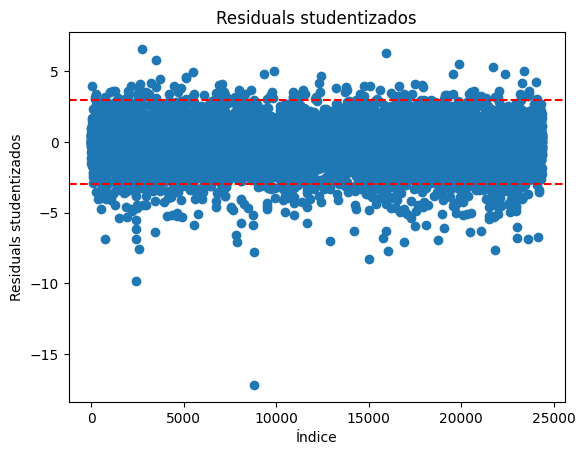

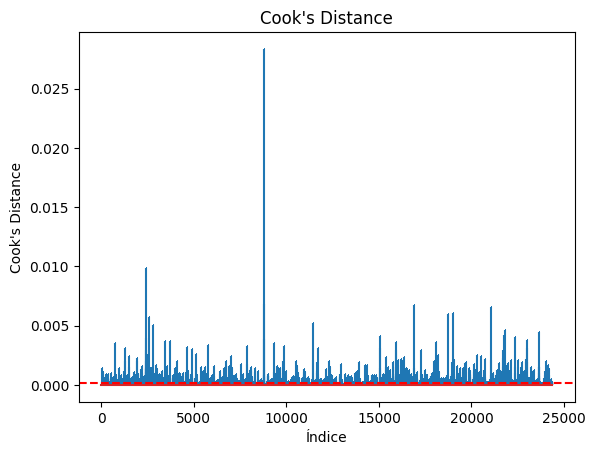

Índices de outliers según residuals studentizados: [   41   214   215   258   283   352   365   525   544   597   629   644
   752   777   795   875   912  1026  1049  1085  1161  1204  1278  1280
  1290  1460  1461  1465  1511  1653  1754  1768  1813  1814  1836  1838
  1844  1890  1908  1909  1928  1964  1973  1995  2145  2151  2222  2289
  2290  2392  2410  2411  2414  2415  2422  2466  2489  2490  2580  2585
  2642  2643  2662  2723  2757  2776  2815  2826  2827  2955  2963  2964
  3044  3099  3108  3177  3258  3259  3348  3445  3446  3506  3527  3534
  3540  3655  3708  3713  3739  3958  4096  4113  4135  4220  4293  4394
  4417  4450  4508  4580  4626  4627  4666  4670  4671  4711  4854  4856
  4892  4905  4922  5109  5112  5120  5150  5367  5489  5512  5554  5556
  5580  5615  5664  5789  6006  6034  6070  6090  6402  6406  6460  6733
  6756  6761  6764  6786  6885  6926  6981  6998  7041  7069  7079  7189
  7223  7233  7241  7245  7290  7316  7503  7563  7567  7682  7765  7846


In [814]:
# Obtener la influencia del modelo winsorizado actual
influence_winsorized = model_winsorized.get_influence()

# Calcular los residuals studentizados
studentized_residuals_winsorized = influence_winsorized.resid_studentized_internal

# Calcular Cook's Distance
cooks_distance_winsorized, _ = influence_winsorized.cooks_distance

# Umbral común para Cook's Distance: 4/n (n = número de observaciones)
cooks_threshold_winsorized = 4 / len(X_winsorized)

# Identificar los outliers con residuals studentizados fuera del rango [-3, 3]
outliers_residuals = np.where(np.abs(studentized_residuals_winsorized) > 3)[0]

# Identificar los outliers con Cook's Distance por encima del umbral
outliers_cooks = np.where(cooks_distance_winsorized > cooks_threshold_winsorized)[0]

# Combinar los índices de outliers (residuals y Cook's Distance)
outliers_combined = np.union1d(outliers_residuals, outliers_cooks)

# Gráfico de residuals studentizados
plt.scatter(range(len(studentized_residuals_winsorized)), studentized_residuals_winsorized)
plt.axhline(y=3, color='r', linestyle='--')
plt.axhline(y=-3, color='r', linestyle='--')
plt.title('Residuals studentizados')
plt.xlabel('Índice')
plt.ylabel('Residuals studentizados')
plt.show()

# Gráfico de Cook's Distance
plt.stem(np.arange(len(cooks_distance_winsorized)), cooks_distance_winsorized, markerfmt=",")
plt.axhline(y=cooks_threshold_winsorized, color='r', linestyle='--')
plt.title('Cook\'s Distance')
plt.xlabel('Índice')
plt.ylabel('Cook\'s Distance')
plt.show()

# Mostrar los índices de los outliers
print(f"Índices de outliers según residuals studentizados: {outliers_residuals}")
print(f"Índices de outliers según Cook's Distance: {outliers_cooks}")


**Identificación de outliers utilizando residuals studentizados**

Los residuals studentizados son los residuos ajustados por su varianza, lo que significa que cada residuo es escalado por su error estándar. Estos valores te permiten identificar outliers más fácilmente, ya que un residuo studentizado mayor a 3 o menor a -3 generalmente indica un outlier. Estos valores extremos representan observaciones que el modelo no predice bien en comparación con el resto de los datos.

De acuerdo a mi gráfica, cualquier punto que supere este rango uede ser considerado un outlier. Los outliers pueden indicar que estas observaciones no siguen el mismo patrón que el resto de los datos, lo que podría estar afectando el ajuste del modelo.

**Identificación de outliers utilizando Cook’s Distance**

Cook’s Distance mide la influencia de una observación individual sobre el ajuste de la regresión. Las observaciones con un valor de Cook’s Distance alto indican que si se eliminara esa observación, el modelo cambiaría significativamente.

Utilicé el criterio de 4/n (n es número de observaciones) para identificar el límite para que un punto se convierta en outlier. Observaciones con valores altos de Cook’s Distance son aquellas que están afectando de manera importante los coeficientes del modelo y pueden ser consideradas para una revisión más detallada o eliminación.

Al tener tantos outliers según las gráficas de arriba, decidí mejor dropearlos (borrarlos) todos, para que no sesgue mi modelo.

In [815]:
# Obtener los índices actuales de X_winsorized y y_full
current_indices = X_winsorized.index

# Asegurarse de que los índices de outliers_combined estén alineados con current_indices
# Mapeamos los índices de los outliers a los índices actuales de X_winsorized
outliers_combined = current_indices[outliers_combined]

# Dropear los outliers tanto en X_winsorized como en y_full
X_cleaned = X_winsorized.drop(index=outliers_combined)
y_cleaned = y_full.drop(index=outliers_combined)

# Verificar las dimensiones después de dropear
print(f"Dimensiones originales de X_winsorized: {X_winsorized.shape}")
print(f"Dimensiones después de dropear outliers: {X_cleaned.shape}")

# Volver a ajustar el modelo sin los outliers
model_cleaned = sm.OLS(y_cleaned, X_cleaned, missing='drop').fit()

# Imprimir el resumen del nuevo modelo
print("\nResumen del modelo sin outliers:")
print(model_cleaned.summary())


Dimensiones originales de X_winsorized: (24369, 7)
Dimensiones después de dropear outliers: (22477, 7)

Resumen del modelo sin outliers:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     332.6
Date:                Fri, 06 Sep 2024   Prob (F-statistic):               0.00
Time:                        21:46:02   Log-Likelihood:                -10737.
No. Observations:               19675   AIC:                         2.149e+04
Df Residuals:                   19668   BIC:                         2.154e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025     

**Comparación del modelo original y el mejorado**

El modelo original tenía un R^2 ajustado de 0.037, mientras que después de aplicar winsorización y eliminar los outliers, el R^2 ajustado aumentó a 0.092. Este incremento sugiere que el modelo mejorado explica una mayor parte de la variabilidad en los rendimientos futuros. Además, las variables como ROIC y EPSP se volvieron más significativas, lo que refuerza la idea de que los outliers estaban distorsionando el ajuste del modelo inicial.

Por eso, el modelo mejorado es claramente mejor que el base, ya que explica una mayor proporción de la varianza de los rendimientos futuros y tiene coeficientes más estables. La winsorización y la eliminación de outliers han ayudado a que el modelo sea más robusto y confiable.

## Interpretación
### Coeficientes beta:
Los coeficientes beta representan la magnitud y cambio de la variable dependiente (DV), que en este caso es "return_y_future" (debido a que queremos predecir los retornos futuros) por cambio en la variable independiente (IV), que en este caso es un conjunto de variables: "ROIC", "log_totalassets", "log_revenue" y "OPM".
### P-value e Intervalo de Confianza
El intervalo de confianza estima el 95% de la probabilidad de que el coeficiente beta esté dentro del modelo de regresión, es decir, la probabilidad de que exista un 95% de confianza de que el intervalo contenga el verdadero valor de un parámetro.
Si el intervalo de confianza no incluye el 0, se sugiere que el coeficiente beta es estadísticamente significativo, pues la variable independiente tiene un efecto sobre la dependiente. Por otro lado, si el intervalo de confianza incluye el 0, no se puede descartar la probabilidad que el coeficiente beta sea 0, es decir, que la IV no tiene efecto sobre la DV.

Esto se relaciona con la hipótesis nula (H0) que dice que un coeficiente beta es 0, que indica que no hay relación lineal entre la IV y la DV, por lo que, al no incluir el 0 en el intervalo de confianza, se puede descartar la hipótesis nula, mientras que, cuando el intervalo de confianza incluye el 0, quiere decir que no hay evidencia suficiente para rechazar la hipótesis nula (no se puede afirmar que existe una relación significativa entre las variables).

El p-value dice qué tan probable es que el coeficiente beta ocurra por mera casualidad, por lo que se usa un umbral de significancia de 0.05 para ver si se considera significativo y que se pueda rechazar la hipótesis nula. Si el p-value es menor a 0.05, el intervalo de confianza del 95% no va a incluir al 0, indicando que el beta es significativamente diferente de 0 y que por ende, tiene efecto en la variable y (que queremos predecir).

### Coeficientes beta obtenidos y su análisis
- ROIC
    - Coeficiente Beta: 0.3022
    - P-value: 0.000
    - Intervalo de Confianza (95%): [0.240, 0.364]
    - Interpretación: Por cada unidad de aumento de ROIC, el retorno futuro aumenta en 0.3022 unidades. El p-value es extremadamente bajo, indicando que el coeficiente es altamente significativo. El intervalo de confianza no incluye el 0, lo que confirma que existe una relación positiva y significativa entre ROIC y los retornos futuros. Las empresas más eficientes en el uso de su capital tienden a generar mayores rendimientos futuros.
- CURRENTRATIO
    - Coeficiente Beta: -0.0103
    - P-value: 0.000
    - Interpretación: Por cada unidad de aumento en el ratio de liquidez corriente (Current Ratio), los retornos futuros disminuyen en 0.0103 unidades. El p-value es bajo, lo que indica que el coeficiente es significativo. El intervalo de confianza no incluye el 0, lo que refuerza que hay una relación negativa y significativa. Esto sugiere que, en este contexto, un alto Current Ratio puede estar asociado con menores retornos futuros, lo que podría reflejar que las empresas con exceso de liquidez no están utilizando de manera óptima sus recursos.
- DEBTTOEQUITY
    - Coeficiente Beta: 0.0073
    - P-value: 0.011
    - Interpretación: Por cada unidad de aumento en el ratio de deuda a patrimonio (Debt to Equity), los retornos futuros aumentan en 0.0073 unidades. Aunque el coeficiente es pequeño, el p-value indica que la relación es estadísticamente significativa. El intervalo de confianza no incluye el 0, lo que sugiere que las empresas que toman más deuda en relación con su patrimonio pueden tener mejores rendimientos futuros, aunque esto conlleva mayor riesgo financiero.
- OPM
    - Coeficiente Beta: 0.1037
    - P-value: 0.000
    - Intervalo de Confianza (95%): [0.057, 0.151]
    - Interpretación: Por cada unidad de aumento del margen operativo (OPM), el retorno futuro aumenta en 0.1037 unidades. El p-value es muy bajo, lo que confirma la significancia estadística, y el intervalo de confianza no incluye el 0. Esto sugiere que una mejor eficiencia operativa está relacionada con mayores retornos futuros.

- EPSP
    - Coeficiente Beta: 0.2250
    - P-value: 0.000
    - Intervalo de Confianza (95%): [0.148, 0.302]
    - Interpretación: Por cada unidad de aumento en las ganancias por acción (EPSP), el retorno futuro aumenta en 0.2250 unidades. Este coeficiente es altamente significativo, y el intervalo de confianza refuerza esta relación positiva. Un mayor EPSP indica una mayor capacidad de generar valor para los accionistas, lo que se traduce en mejores retornos futuros.

- BOOKMARKET
    - Coeficiente Beta: 0.1306
    - P-value: 0.000
    - Intervalo de Confianza (95%): [0.113, 0.148]
    - Interpretación: Por cada unidad de aumento en el ratio de valor en libros a valor de mercado (BOOKMARKET), el retorno futuro aumenta en 0.1306 unidades. El p-value es extremadamente bajo, lo que indica significancia estadística, y el intervalo de confianza no incluye el 0, lo que confirma la relación positiva entre BOOKMARKET y los retornos futuros. Las empresas con un alto valor en libros en relación con su valor de mercado tienden a tener mayores rendimientos futuros.

In [816]:
# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_cleaned.columns
vif_data["VIF"] = [variance_inflation_factor(X_cleaned.values, i) for i in range(X_cleaned.shape[1])]

# Mostrar los resultados de VIF
print(vif_data)


       Variable       VIF
0         const  6.664555
1           OPM  3.790937
2          ROIC  4.933937
3  CURRENTRATIO  1.235963
4  DEBTTOEQUITY  1.173210
5          EPSP  2.756985
6    BOOKMARKET  1.020874


**Multicolienalidad**

La multicolinealidad ocurre cuando dos o más variables independientes en un modelo de regresión están altamente correlacionadas entre sí. Esto significa que las variables no aportan información completamente nueva al modelo, ya que están midiendo algo muy similar. El problema principal con la multicolinealidad es que puede inflar los errores estándar de los coeficientes estimados, lo que a su vez puede hacer que los p-values sean más altos. Cuando esto ocurre, podría parecer que una variable no tiene una influencia significativa en la variable dependiente, aunque en realidad sí la tenga.

**Prueba VIF**

Para detectar multicolinealidad, se utiliza el Factor de Inflación de la Varianza (VIF), que mide cuánto aumenta la varianza de un coeficiente de regresión debido a la colinealidad con otras variables. Un VIF alto (generalmente por encima de 10) indica un problema de multicolinealidad, mientras que valores más bajos sugieren que las variables están relativamente independientes entre sí.

**¿Multicolienalidad en mis datos?**

En mis datos, los valores de VIF están todos por debajo de 10, lo que sugiere que no tengo un problema serio de multicolinealidad. Los valores más altos, como el de la constante (VIF = 6.66) y ROIC (VIF = 4.93), son indicadores de una posible correlación, pero no lo suficientemente altos como para preocuparme. Esto indica que, aunque algunas variables tienen algo de correlación, no es suficiente para que la multicolinealidad sea un problema grave en mi modelo.


**Interpretación del Adjusted R-square del modelo**

El Adjusted R-square es una medida clave en los modelos de regresión porque permite entender qué porcentaje de la variabilidad en la variable dependiente (return_y_future) está siendo explicado por las variables independientes (OPM, ROIC, Current Ratio, Debt to Equity, EPSP, Book to Market), ajustando este valor según el número de predictores en el modelo.

En este caso, el Adjusted R-square es de 0.092, lo que significa que el 9.2% de la variabilidad en los rendimientos futuros de las empresas manufactureras puede explicarse a través de las variables financieras seleccionadas. Aunque este valor puede parecer bajo, es común en modelos financieros, pues son modelos con demasiadas variables lo que los vuelven demasiado complejos de predecir con gran exactitud. 

El hecho de que el valor sea bajo no necesariamente significa que el modelo no sea útil, sino que indica que hay otros factores, posiblemente no financieros o más específicos de cada empresa, que afectan a los rendimientos futuros. 

**Variable con mayor poder explicativo**

Al observar los coeficientes y los p-values de cada variable, la que tiene mayor impacto positivo en los rendimientos futuros es el ROIC (Return on Invested Capital). El coeficiente beta asociado con el ROIC es de 0.3022, lo que significa que, por cada unidad adicional de ROIC, los rendimientos futuros aumentan en 0.3022 unidades. Además, el p-value asociado con ROIC es extremadamente bajo (0.000), lo que indica que esta relación es estadísticamente significativa.

En términos financieros, el ROIC mide lo eficientemente que una empresa está utisando su capital invertido para generar retornos. Un alto ROIC indica que una empresa está maximizando el valor que obtiene de sus inversiones, lo que suele ser una señal positiva para los inversionistas. Un ROIC positivo y significativo en el modelo sugiere que las empresas que logran mayores retornos sobre su capital tienen una mayor probabilidad de generar rendimientos positivos en el mercado de acciones. Esto es clave para la toma de decisiones, ya que los inversionistas pueden utilizar esta información para identificar empresas que están utilizando eficientemente su capital y tienen potencial de crecimiento.

**Interpretación de un coeficiente negativo y significativo**

En este modelo, el Current Ratio tiene un valor negativo de -0.0103, y es bastante significativo porque el p-value es 0.000. Esto significa que, por cada unidad que aumenta el Current Ratio, los rendimientos futuros de la empresa bajan un poquito, específicamente 0.0103 unidades.

El Current Ratio nos dice qué tan bien una empresa puede pagar sus deudas a corto plazo usando sus activos actuales. Normalmente, un Current Ratio alto se ve como algo positivo porque muestra que la empresa puede cubrir sus deudas fácilmente. Pero si este ratio es demasiado alto, puede ser una señal de que la empresa está siendo demasiado conservadora o no está aprovechando bien sus activos. En este caso, el hecho de que sea negativo sugiere que las empresas con Current Ratios más altos tienden a tener peores rendimientos en el futuro. Esto podría ser porque están acumulando demasiada liquidez o activos sin invertirlos de manera efectiva para crecer.

Desde el punto de vista de los inversionistas o los directores de la empresa, este resultado les advierte que tener un Current Ratio demasiado alto no siempre es algo bueno. De hecho, en el sector manufacturero, mantener mucho efectivo o activos sin usarlos podría afectar negativamente los rendimientos futuros. Lo mejor sería encontrar un equilibrio entre tener suficiente liquidez para cubrir deudas y, al mismo tiempo, usar esos activos de manera eficiente para hacer crecer el negocio y mejorar los rendimientos.

**Conclusiones**

- ROIC (Return on Invested Capital) es la variable más importante en este modelo para explicar los rendimientos futuros. Esto tiene sentido porque las empresas que utilizan eficientemente su capital tienen más probabilidades de generar altos rendimientos para los inversionistas. Para decisiones estratégicas, las empresas deben enfocarse en maximizar su ROIC, asegurándose de que el capital invertido esté generando retornos significativos.

- Current Ratio tiene un impacto negativo significativo en los rendimientos futuros. Un Current Ratio demasiado alto puede estar indicando que las empresas están siendo demasiado conservadoras con sus activos corrientes, lo que podría estar afectando negativamente su rendimiento en el mercado. Para mejorar su competitividad, las empresas deben evaluar si están manteniendo demasiados activos en lugar de invertir en oportunidades de crecimiento.

- Multicolinealidad no parece ser un problema significativo en este modelo, lo que indica que las variables independientes no están demasiado correlacionadas entre sí. Esto me da confianza en que cada variable aporta información valiosa al modelo sin redundancia, lo que me ayuda a interpretar los coeficientes con mayor claridad.
